In [1]:
from samap.mapping import SAMAP
from samap.analysis import (get_mapping_scores, GenePairFinder,
                            sankey_plot, chord_plot, CellTypeTriangles, 
                            ParalogSubstitutions, FunctionalEnrichment,
                            convert_eggnog_to_homologs, GeneTriangles)
import samap.utils
from samalg import SAM
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sn 
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.manifold import MDS 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce
import os
import glob
import anndata as ad
from multiprocessing import Pool
from itertools import repeat
import scib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

scaler = StandardScaler()

nIter = 10

/global/home/users/dtommasini/.conda/envs/samap2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Building homology graph

In [70]:
# Read in keys between protein ids and gene names
index = pd.DataFrame({'ident': ['ze','ch','li','op','sq','hs'], 
                      'name': ['Zebrafish_lyu', 'Chicken', 'Lizard', 'Opossum_mMonDom1', 'Squirrel', 'Human']})

keys = dict((row['ident'], pd.read_csv("Keys/" + row['name'] + "_key.csv", index_col=0).to_numpy()) for index,row in index.iterrows())
keys

{'ze': array([['ENSDART00000189431.1', 'BX681417.25'],
        ['ENSDART00000189226.1', 'BX681417.24'],
        ['ENSDART00000172037.2', 'trgv7'],
        ...,
        ['ENSDART00000093623.3', 'mt-nd6'],
        ['ENSDART00000093625.3', 'mt-cyb'],
        ['ENSDART00000111052.4', 'olig3']], dtype=object),
 'ch': array([['XP_025008417.1', 'LOC112532827'],
        ['XP_025008525.1', 'LOC107049475'],
        ['XP_025008521.1', 'LOC107049475'],
        ...,
        ['XP_025002305.1', 'LOC112531446'],
        ['XP_025002276.1', 'LOC425607'],
        ['XP_025002273.1', 'LOC107050604']], dtype=object),
 'li': array([['XP_060610900.1', 'LOC132761864'],
        ['XP_060641228.1', 'LOC132781182'],
        ['XP_060641014.1', 'LOC132781058'],
        ...,
        ['XP_060644501.1', 'LOC132783386'],
        ['XP_060644502.1', 'LOC132783387'],
        ['XP_060644503.1', 'LOC132783388']], dtype=object),
 'op': array([['XP_056650550.1', 'LOC130453517'],
        ['XP_056650623.1', 'LOC130453802'],
    

In [4]:
# Read in keys between protein ids and gene names
index = pd.DataFrame({'ident': ['ze','ch','li','op','sq','hs'], 
                      'name': ['Zebrafish', 'Chicken', 'Lizard', 'Opossum_mMonDom1', 'Squirrel', 'Human']})

keys = dict((row['ident'], pd.read_csv("Keys/" + row['name'] + "_key.csv", index_col=0).to_numpy()) for index,row in index.iterrows())
keys.update({'ze': pd.read_csv("Keys/Zebrafish_key_old.csv", index_col=0).to_numpy()})
keys

{'ze': array([['XM_009305058.3', 'cep97'],
        ['NM_198371.2', 'cep97'],
        ['XM_021475913.1', 'nfkbiz'],
        ...,
        ['XM_021471071.1', 'LOC110438518'],
        ['XM_021471074.1', 'LOC110438534'],
        ['XM_021471077.1', 'LOC110438537']], dtype=object),
 'ch': array([['XP_025008417.1', 'LOC112532827'],
        ['XP_025008525.1', 'LOC107049475'],
        ['XP_025008521.1', 'LOC107049475'],
        ...,
        ['XP_025002305.1', 'LOC112531446'],
        ['XP_025002276.1', 'LOC425607'],
        ['XP_025002273.1', 'LOC107050604']], dtype=object),
 'li': array([['XP_060610900.1', 'LOC132761864'],
        ['XP_060641228.1', 'LOC132781182'],
        ['XP_060641014.1', 'LOC132781058'],
        ...,
        ['XP_060644501.1', 'LOC132783386'],
        ['XP_060644502.1', 'LOC132783387'],
        ['XP_060644503.1', 'LOC132783388']], dtype=object),
 'op': array([['XP_056650550.1', 'LOC130453517'],
        ['XP_056650623.1', 'LOC130453802'],
        ['XP_056650626.1', 'LOC1304

In [5]:
path = '../../Species_Objects/Cone_Objects/updated/'
specieslist = ['Zebrafish', 'Chicken', 'Lizard', 'Opossum', 'Squirrel', 'Human']
identlist = ['ze', 'ch', 'li', 'op', 'sq', 'hs']
updated10 = dict((identlist[i], path + species + '_single_10.h5ad') for i, species in enumerate(specieslist))
updated11 = dict((identlist[i], path + species + '_single_11.h5ad') for i, species in enumerate(specieslist))
updated12 = dict((identlist[i], path + species + '_single_12.h5ad') for i, species in enumerate(specieslist))
updated10

{'ze': '../../Species_Objects/Cone_Objects/updated/Zebrafish_single_10.h5ad',
 'ch': '../../Species_Objects/Cone_Objects/updated/Chicken_single_10.h5ad',
 'li': '../../Species_Objects/Cone_Objects/updated/Lizard_single_10.h5ad',
 'op': '../../Species_Objects/Cone_Objects/updated/Opossum_single_10.h5ad',
 'sq': '../../Species_Objects/Cone_Objects/updated/Squirrel_single_10.h5ad',
 'hs': '../../Species_Objects/Cone_Objects/updated/Human_single_10.h5ad'}

In [6]:
# Generate homology graph
sm = RunSAM(updated10, keys = keys, blast_dir = 'maps/')
samap.utils.save_samap(sm, "../../../storage/samap/pkl/sm_zeUCSC_chNCBI_liNCBI_opNCBI_sqENS_hsENS.samap")

Processing data ze from:
../../Species_Objects/Cone_Objects/updated/Zebrafish_single_10.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.9140943288875489
Iteration: 2, Convergence: 0.013225238226039349
Computing the UMAP embedding...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Elapsed time: 15.41897702217102 seconds
Not updating the manifold...
Processing data ch from:
../../Species_Objects/Cone_Objects/updated/Chicken_single_10.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8917331656627212
Iteration: 2, Convergence: 0.022296685116706714
Computing the UMAP embedding...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Elapsed time: 4.188571929931641 seconds
Not updating the manifold...
Processing data li from:
../../Species_Objects/Cone_Objects/updated/Lizard_single_10.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8259862528788142
Iteration: 2, Convergence: 0.037985242243543216
Iteration: 3, Convergence: 0.013560596021698821
Computing the UMAP embedding...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Elapsed time: 4.7101030349731445 seconds
Not updating the manifold...
Processing data op from:
../../Species_Objects/Cone_Objects/updated/Opossum_single_10.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.909601285435882
Iteration: 2, Convergence: 0.025259541628161953
Computing the UMAP embedding...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Elapsed time: 3.1942222118377686 seconds
Not updating the manifold...
Processing data sq from:
../../Species_Objects/Cone_Objects/updated/Squirrel_single_10.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8819811356214661
Iteration: 2, Convergence: 0.02737255124237983
Computing the UMAP embedding...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Elapsed time: 3.3904824256896973 seconds
Not updating the manifold...
Processing data hs from:
../../Species_Objects/Cone_Objects/updated/Human_single_10.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.9335348845987222
Iteration: 2, Convergence: 0.03265319532034036
Iteration: 3, Convergence: 0.012651681555948742
Computing the UMAP embedding...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Elapsed time: 4.445237398147583 seconds
Not updating the manifold...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/samap/mapping.py:1186: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss = ss[np.unique(q(ss.index),return_index=True)[1]]


14212 `ze` gene symbols match between the datasets and the BLAST graph.
16317 `ch` gene symbols match between the datasets and the BLAST graph.
19629 `li` gene symbols match between the datasets and the BLAST graph.
21005 `op` gene symbols match between the datasets and the BLAST graph.
17392 `sq` gene symbols match between the datasets and the BLAST graph.
19373 `hs` gene symbols match between the datasets and the BLAST graph.


# Load pre-computed homology graph

In [5]:
sm_ref = samap.utils.load_samap("../../../storage/samap/pkl/sm_updated.samap")
gnnm = (sm_ref.gnnm, sm_ref.gns, sm_ref.gns_dict)

# File paths

In [4]:
path = '../../Species_Objects/Cone_Objects/updated/'
specieslist = ['ZebrafishAdult', 'Chicken', 'Lizard', 'Opossum', 'Squirrel', 'Human']
identlist = ['ze', 'ch', 'li', 'op', 'sq', 'hs']
controlfiles = dict((identlist[i], path + species + '_single.h5ad') for i, species in enumerate(specieslist))
expfiles = dict((identlist[i], path + species + '_double.h5ad') for i, species in enumerate(specieslist))
controlfiles

{'ze': '../../Species_Objects/Cone_Objects/updated/ZebrafishAdult_single.h5ad',
 'ch': '../../Species_Objects/Cone_Objects/updated/Chicken_single.h5ad',
 'li': '../../Species_Objects/Cone_Objects/updated/Lizard_single.h5ad',
 'op': '../../Species_Objects/Cone_Objects/updated/Opossum_single.h5ad',
 'sq': '../../Species_Objects/Cone_Objects/updated/Squirrel_single.h5ad',
 'hs': '../../Species_Objects/Cone_Objects/updated/Human_single.h5ad'}

# Zebrafish adult

In [ ]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(controlfiles, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        controlres = p.starmap(wrapper, zip(range(nIter), repeat(100)))

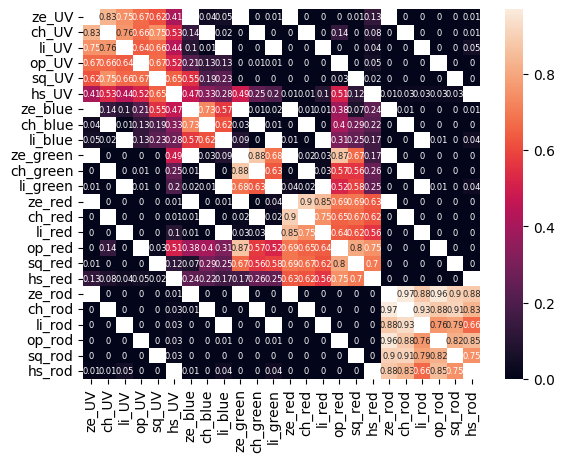

In [7]:
# element-wise mean
MeanTable(controlres)

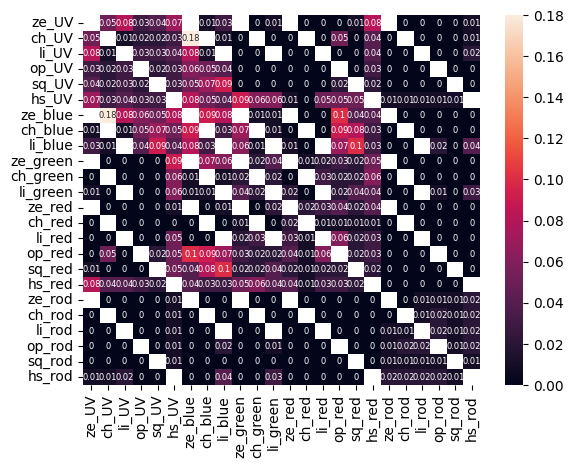

In [34]:
# element-wise sd
std = pd.DataFrame(np.std(controltables, axis=0), columns=controltables[0].columns, index=controltables[0].index)
PlotHeatmap(std)

In [27]:
# save tables as csv files
# os.mkdir('MappingTable')
[controlres[i][1].to_csv('MappingTable/controlfiles_' + str(i) + '.csv') for i in range(nIter)]


[None, None, None, None, None, None, None, None, None, None]

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

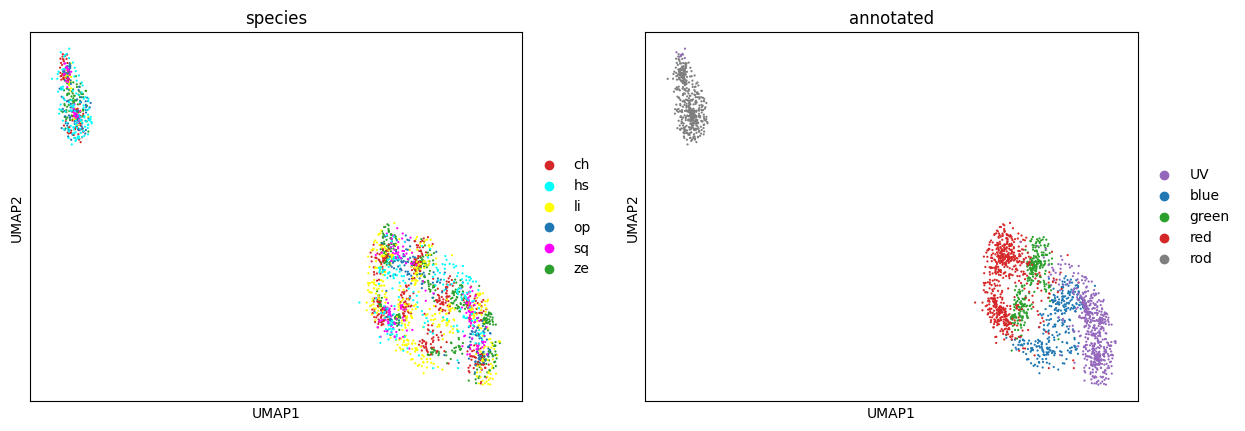

In [28]:
# save an example sm
PlotUMAP(controlres[1][0], size=10)
samap.utils.save_samap(controlres[1][0], '../../../storage/samap/pkl/controlfiles_example.samap')


# Chick and lizard

In [18]:
path = '../../Species_Objects/Cone_Objects/updated/'
specieslist = ['Chicken', 'Lizard']
identlist = ['ch', 'li']
chli_single = dict((identlist[i], path + species + '_single.h5ad') for i, species in enumerate(specieslist))
chli_double = dict((identlist[i], path + species + '_double.h5ad') for i, species in enumerate(specieslist))
chli_swapch = my_dict = {'ch': path + 'Chicken_single.h5ad', 'li': path + 'Lizard_double.h5ad'}
chli_swapli = my_dict = {'ch': path + 'Chicken_double.h5ad', 'li': path + 'Lizard_single.h5ad'}
chli_swapch

{'ch': '../../Species_Objects/Cone_Objects/updated/Chicken_single.h5ad',
 'li': '../../Species_Objects/Cone_Objects/updated/Lizard_double.h5ad'}

/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_54371/3741285

RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAMRUNNING SAM
RUNNING SAM
RUNNING SAMIteration: 0, Convergence: 1.0

RUNNING SAMRUNNING SAM


Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0

RUNNING SAM



Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8906712328941204Iteration: 1, Convergence: 0.8910924933811594

Iteration: 1, Convergence: 0.89216462789739
Iteration: 1, Convergence: 0.8915776582159415
Iteration: 1, Convergence: 0.8929697470197551Iteration: 1, Convergence: 0.8904350472854042

Iteration: 1, Convergence: 0.89015077344881
Iteration: 1, Convergence: 0.8914633980942301
Iteration: 1, Convergence: 0.8911032392995171
Iteration: 1, Convergence: 0.8921366498603962
Iteration: 2, Convergence: 0.02249539114413313
Iteration: 2, Convergence: 0.021864224210845145
Iteration: 2, Conve

Prepping datasets for translation.
Projecting data into joint latent space. 0.5326550006866455
Translating feature spaces pairwise.
Correcting data with means. 0.5017781257629395
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Correcting data with means. 0.44946837425231934
Projecting data into joint latent space. 0.6405467987060547
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Rescaling edge weights by expression correlations.
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Prepping datasets for translation.
Correcting data with means. 0.5570049285888672
Iteration 3 complete.
Alignment scores:
          ch        li
ch  0.000000  0.668097
li  0.721785  0.000000
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Concatenating SAM objects...
Translating feature spaces pairwise.
Iteration 2 c

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ig

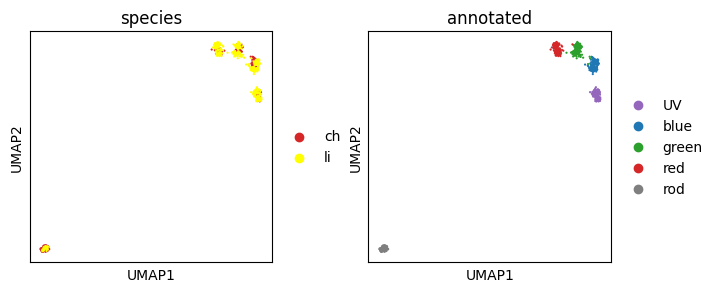

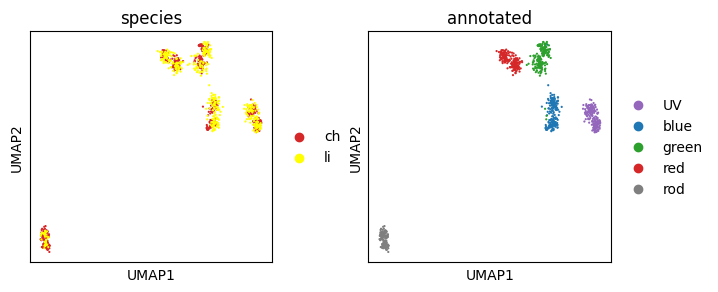

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 0.8274027784665425 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

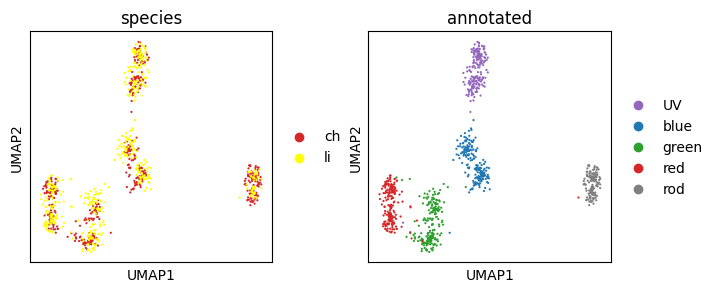

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 0.9028855403264363 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Elapsed time: 0.9172342975934347 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the

Elapsed time: 0.8682937026023865 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


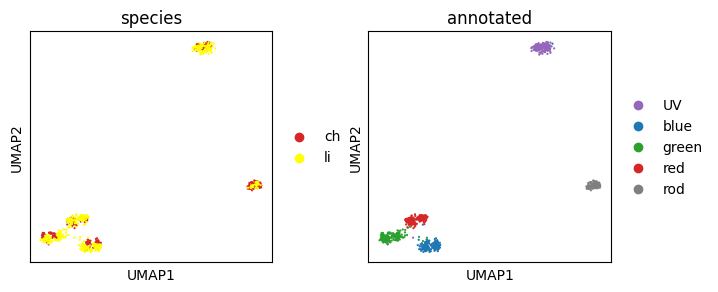

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Elapsed time: 0.9902960181236267 minutes.
Finding cluster-specific markers in ch:annotated.


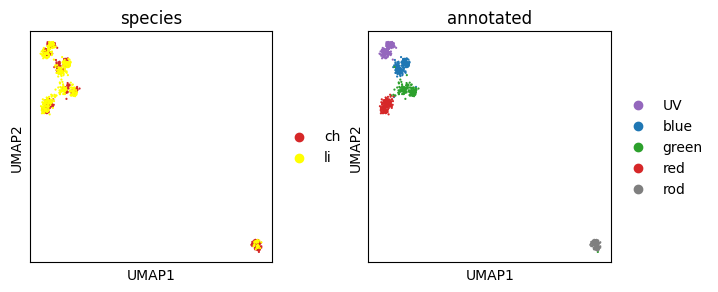

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in ch:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


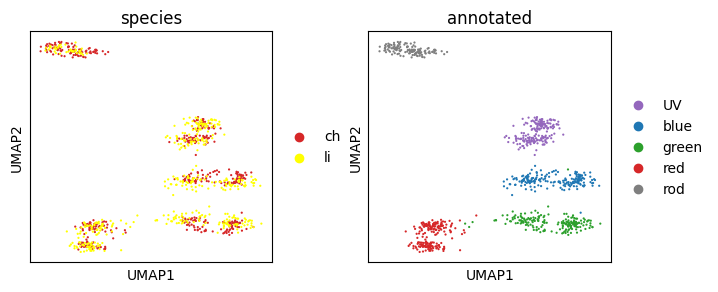

Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.


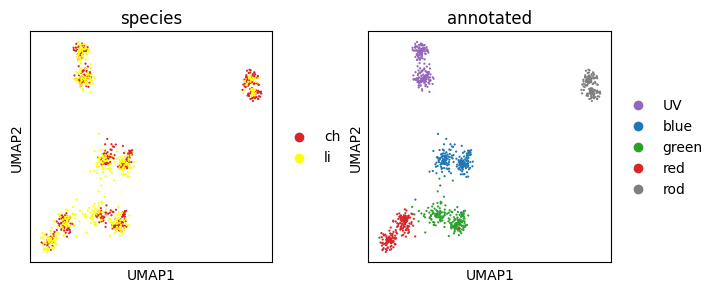

Finding cluster-specific markers in ch:annotated.
Elapsed time: 0.8338271061579386 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

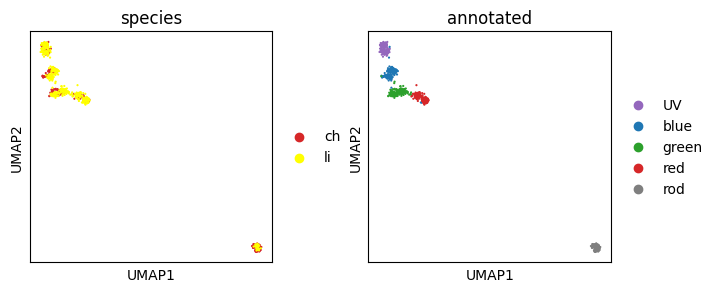

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 0.8145710945129394 minutes.
Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.


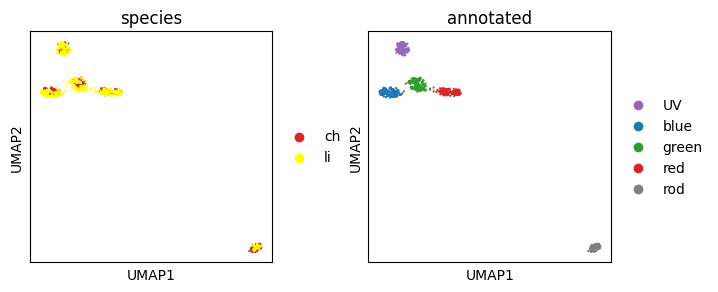

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 0.7811911265055339 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

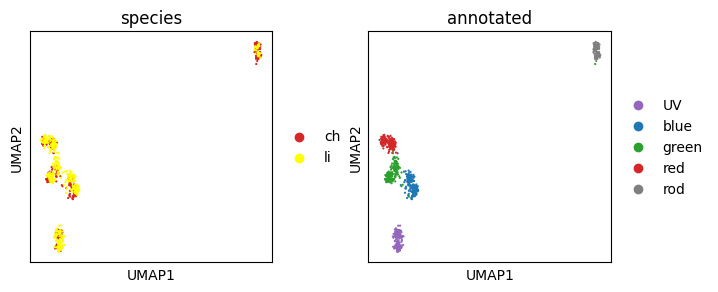

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.


In [10]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(chli_single, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        chli_single_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

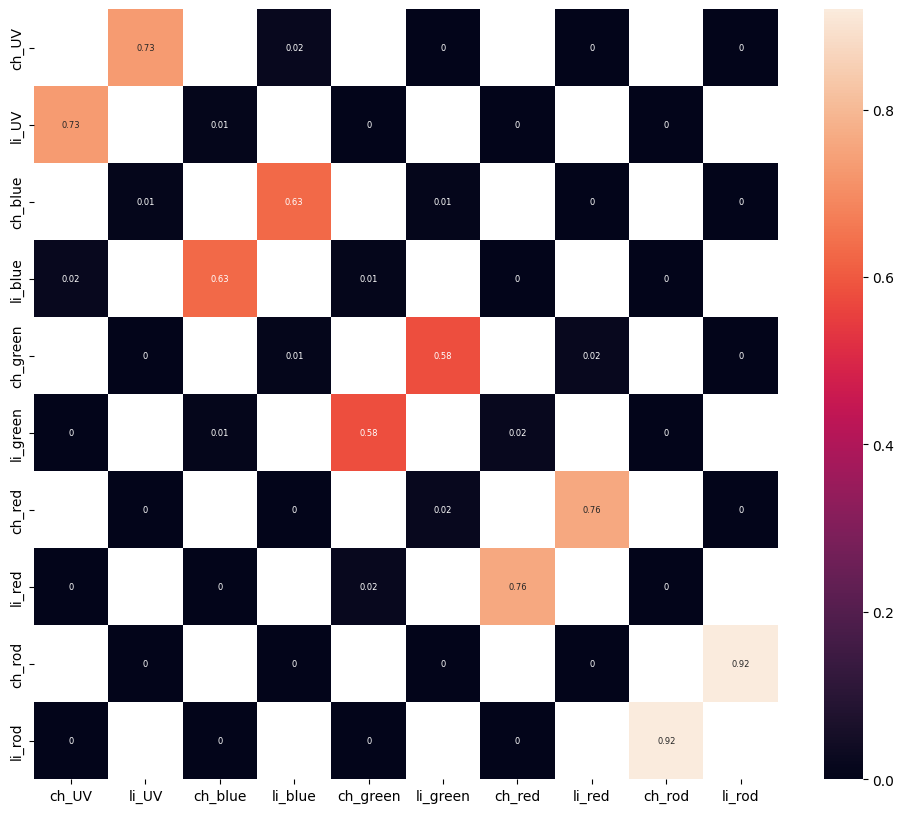

In [11]:
MeanTable(chli_single_res)

/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_54371/3741285

RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_54371/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAMRUNNING SAM
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 0, Convergence: 1.0RUNNING SAM

RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 0, Convergence: 1.0RUNNING SAM

Iteration: 0, Convergence: 1.0

Iteration: 0, Convergence: 1.0
RUNNING SAMRUNNING SAM
Iteration: 0, Convergence: 1.0

RUNNING SAM
Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0

Iteration: 1, Convergence: 0.8901029823127871
Iteration: 1, Convergence: 0.8902317079507902
Iteration: 1, Convergence: 0.889892092989811
Iteration: 1, Convergence: 0.8915077632020446Iteration: 1, Convergence: 0.8910337206525951

Iteration: 1, Convergence: 0.8905055254375235
Iteration: 1, Convergence: 0.8910670780843978
Iteration: 1, Convergence: 0.891663319236937
Iteration: 1, Convergence: 0.890178951282264
Iteration: 1, Convergence: 0.8906080372570431
Iteration: 2, Convergence: 0.015677462603253214
Iteration: 2, Convergence: 0.015632655205781058
Iteration: 2, Convergence: 0.015430760165011497
Iteration: 2

Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 2 complete.
Alignment scores:
          ch        li
ch  0.000000  0.706417
li  0.711595  0.000000
Calculating gene-gene correlations in the homology graph...
Prepping datasets for translation.
Translating feature spaces pairwise.
Prepping datasets for translation.
Translating feature spaces pairwise.
Prepping datasets for translation.
Prepping datasets for translation.
Translating feature spaces pairwise.
Translating feature spaces pairwise.
Projecting data into joint latent space. 0.639272928237915
Projecting data into joint latent space. 0.5793547630310059
Prepping datasets for translation.
Projecting data into joint latent space. 0.8675034046173096
Projecting data into joint latent space. 0.9193112850189209
Correcting data with means. 0.6568870544433594
Translating feature spaces pairwise.
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
P

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

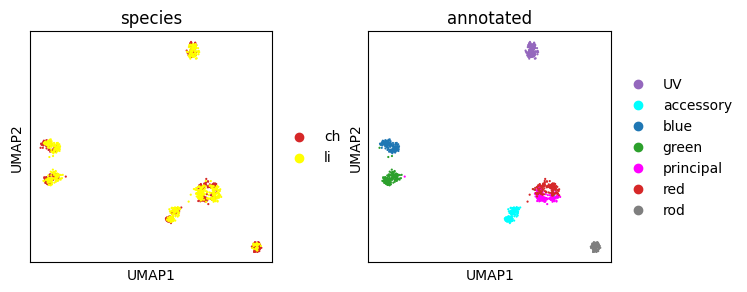

Finding cluster-specific markers in ch:annotated.
Elapsed time: 1.020673946539561 minutes.
Elapsed time: 1.0481160640716554 minutes.
Elapsed time: 0.9902851581573486 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ig

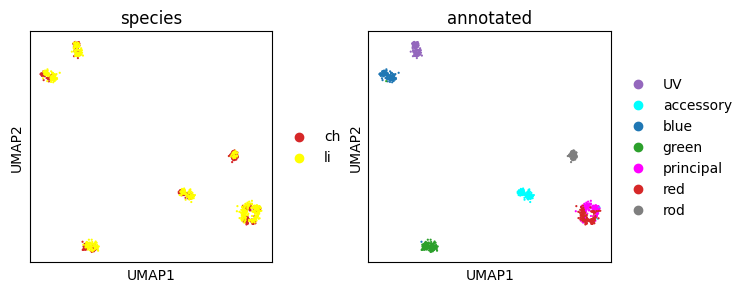

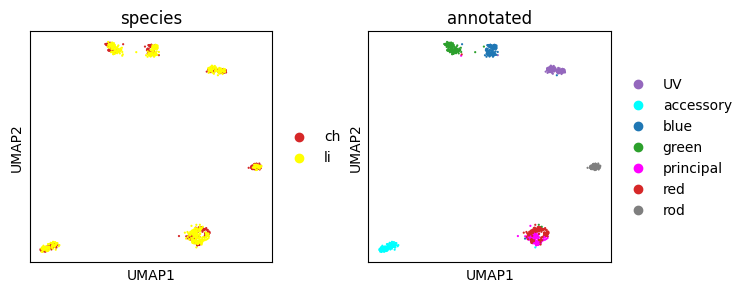

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.


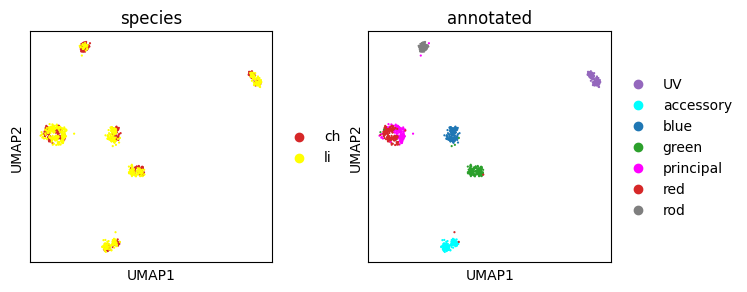

Finding cluster-specific markers in ch:annotated.
Elapsed time: 0.9695906519889832 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

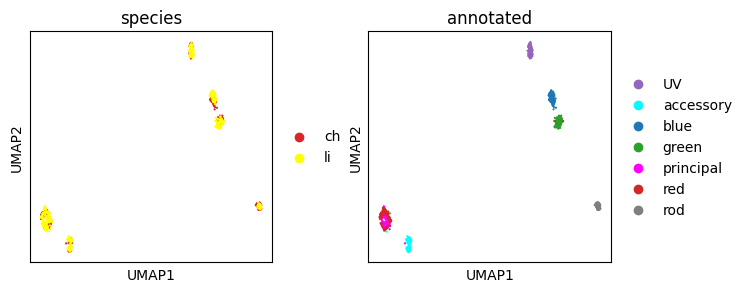

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 0.9017275015513102 minutes.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.
Elapsed time: 0.9956951459248861 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

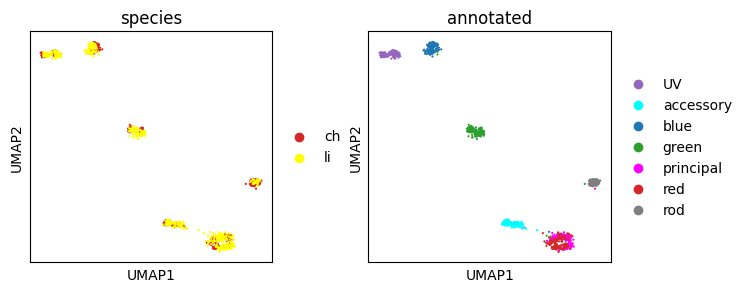

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in ch:annotated.
Elapsed time: 0.9268125454584758 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

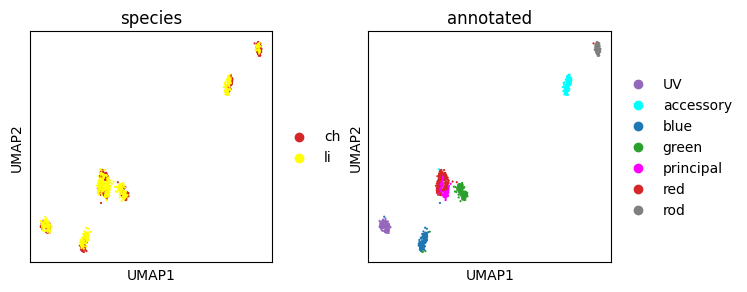

Finding cluster-specific markers in ch:annotated.
Elapsed time: 0.9158254941304524 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

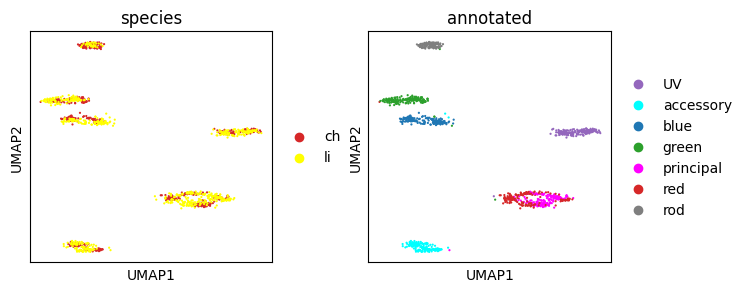

Finding cluster-specific markers in ch:annotated.


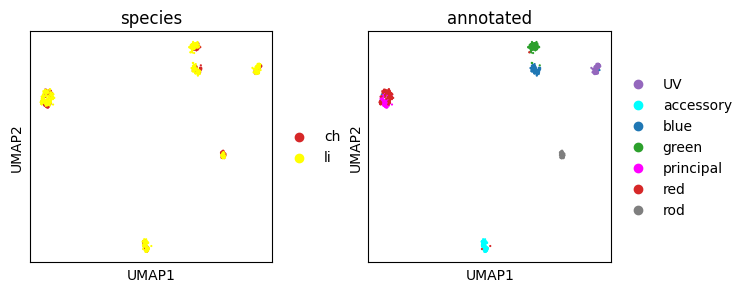

Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 0.8484284241994222 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

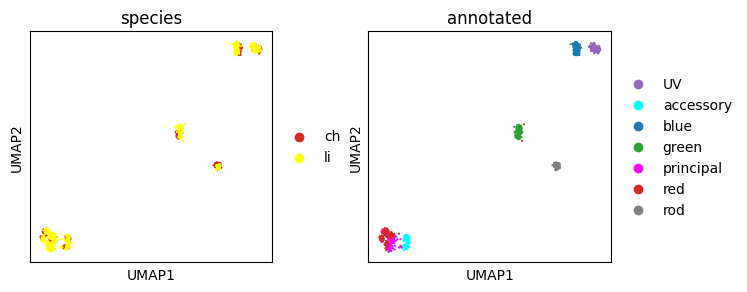

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.


In [12]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(chli_double, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        chli_double_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

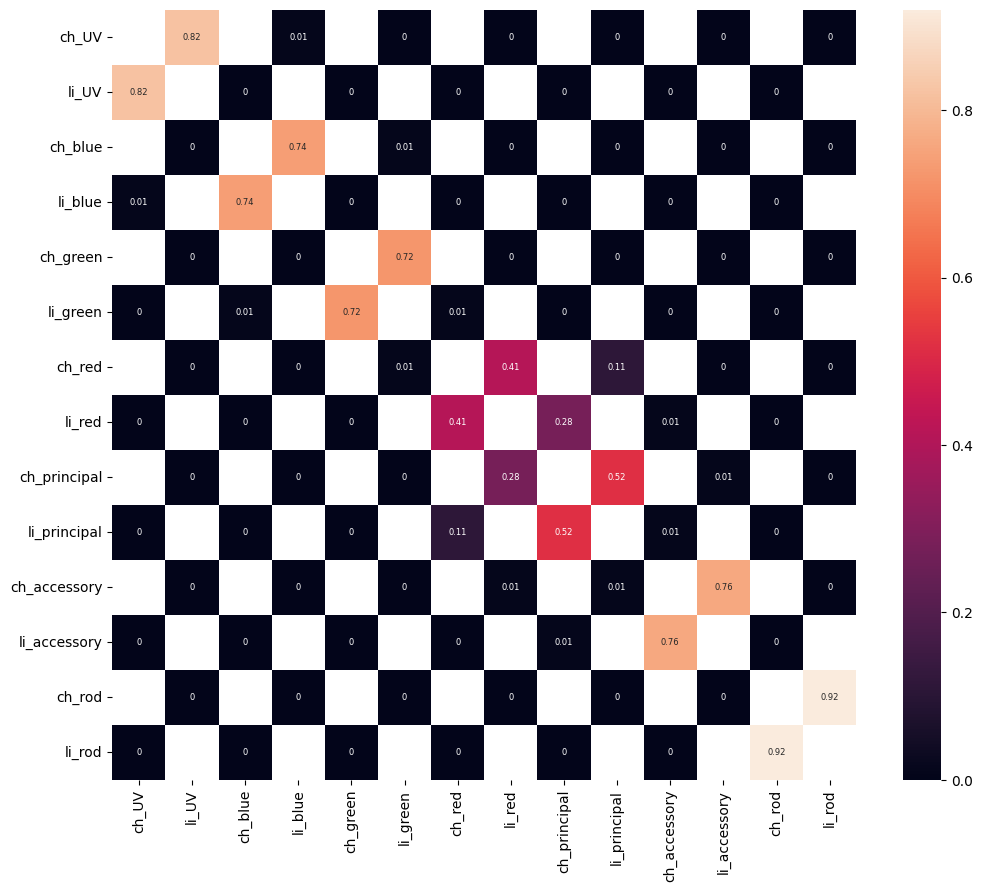

In [13]:
MeanTable(chli_double_res)

/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746

RUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAM




Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0


RUNNING SAM


RUNNING SAMRUNNING SAM
RUNNING SAMRUNNING SAMIteration: 0, Convergence: 1.0

Iteration: 0, Convergence: 1.0

Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0

Iteration: 0, Convergence: 1.0

Iteration: 1, Convergence: 0.89216462789739
Iteration: 1, Convergence: 0.8914633980942301
Iteration: 1, Convergence: 0.89015077344881
Iteration: 1, Convergence: 0.8929697470197551
Iteration: 1, Convergence: 0.8915776582159415
Iteration: 1, Convergence: 0.8911032392995171
Iteration: 1, Convergence: 0.8904350472854042
Iteration: 2, Convergence: 0.021864224210845145
Iteration: 1, Convergence: 0.8906712328941204
Iteration: 1, Convergence: 0.8910924933811594
Iteration: 1, Convergence: 0.8921366498603962
Iteration: 2, Convergence: 0.021296004200705893
Iteration: 2, Conv

Rescaling edge weights by expression correlations.
Prepping datasets for translation.
Translating feature spaces pairwise.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        li
ch  0.000000  0.681483
li  0.634838  0.000000
Running UMAP on the stitched manifolds.
Projecting data into joint latent space. 0.5745706558227539
Correcting data with means. 0.3641326427459717
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 2 complete.
Alignment scores:
          ch        li
ch  0.000000  0.673691
li  0.638618  0.000000
Calculating gene-gene correlations in the homology graph...
Prepping datasets for translation.
Translating feature spaces pairwise.
Prepping datasets for translation.
Translating feature spaces pairwise.
Projecting data into joint latent space. 0.6456155776977539
Projecting data into joint latent s

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Rescaling edge weights by expression correlations.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Correcting data with means. Running UMAP on the stitched manifolds.0.4995391368865967

Correcting data with means. 0.6397523880004883
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening


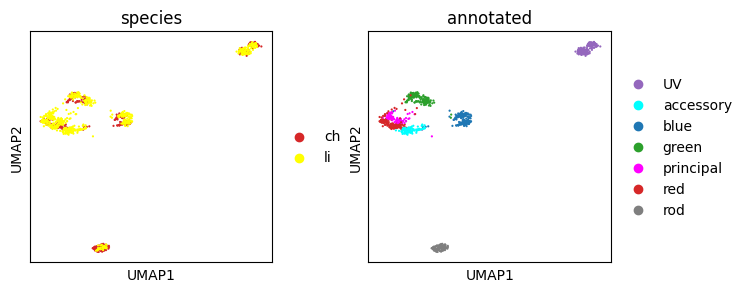

Concatenating SAM objects...
Finding cluster-specific markers in ch:annotated.
Iteration 3 complete.
Alignment scores:
         ch        li
ch  0.00000  0.670856
li  0.63515  0.000000
Rescaling edge weights by expression correlations.
Rescaling edge weights by expression correlations.
Running UMAP on the stitched manifolds.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        li
ch  0.000000  0.690319
li  0.634758  0.000000
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch       li
ch  0.000000  0.68725
li  0.656811  0.00000
Running UMAP on the stitched manifolds.
Running UMAP on the stitched manifolds.
Finding cluster-specific markers in li:annotated.
Prepping datasets for translation.
Translating feature spaces pairwise.
Prepping datasets for translation.
Translating feature spaces pairwise.
Projecting data into joint latent space. 0.541001558303833
Projecting data into joint latent space. 0.5329627990722656
Correct

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

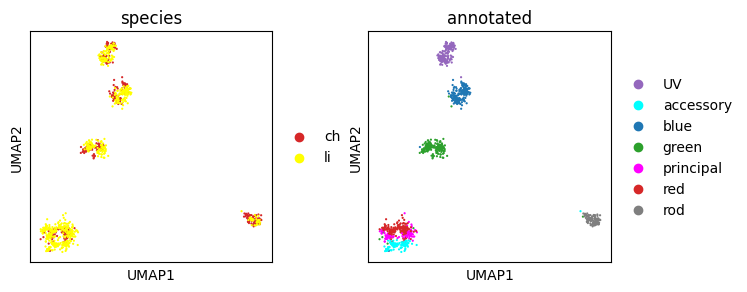

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Prepping datasets for translation.
Elapsed time: 1.0185157577196757 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Translating feature spaces pairwise.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Elapsed time: 1.2003993431727091 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

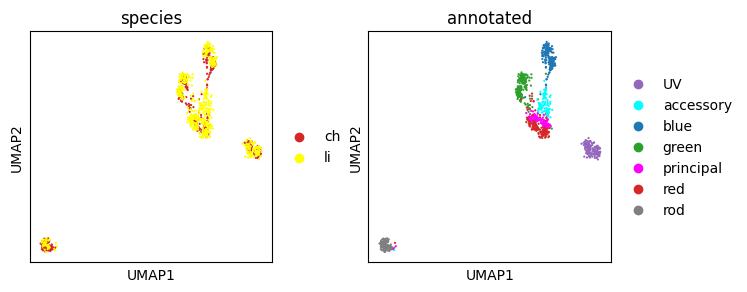

Finding cluster-specific markers in ch:annotated.


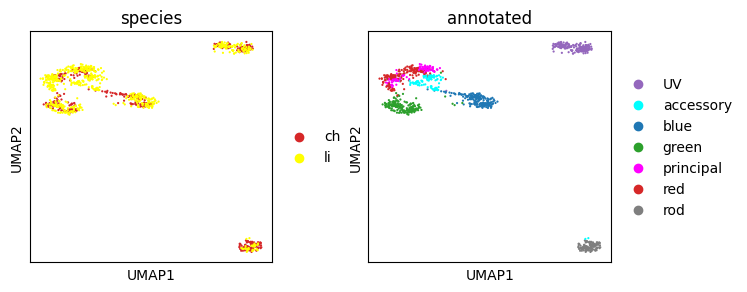

Projecting data into joint latent space. 0.5229701995849609
Finding cluster-specific markers in ch:annotated.
Elapsed time: 1.072457730770111 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

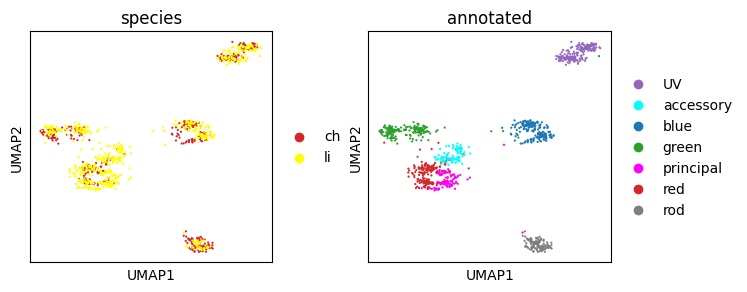

Finding cluster-specific markers in ch:annotated.
Correcting data with means. 0.396115779876709
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Finding cluster-specific markers in li:annotated.
Elapsed time: 1.0878639141718547 minutes.
Rescaling edge weights by expression correlations.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Elapsed time: 1.046545422077179 minutes.
Concatenating SAM objects...


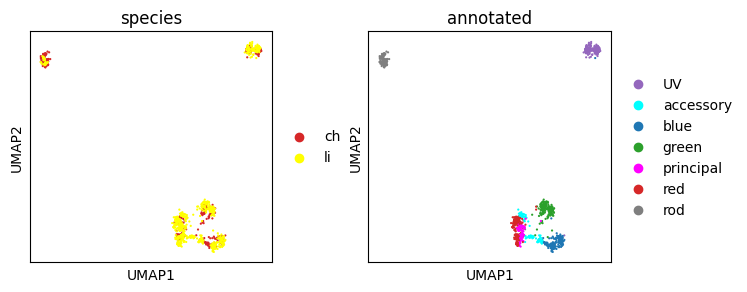

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Iteration 3 complete.
Alignment scores:
         ch        li
ch  0.00000  0.694128
li  0.65801  0.000000


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in ch:annotated.
Elapsed time: 1.0229509075482686 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


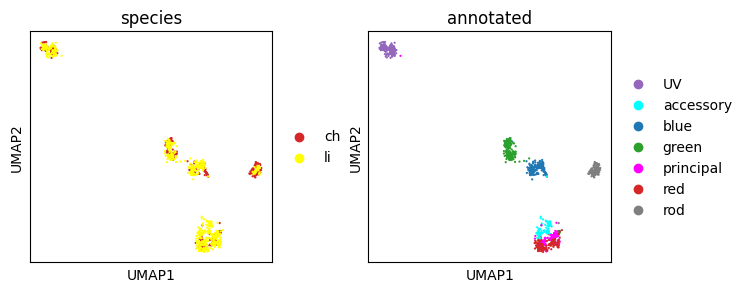

Finding cluster-specific markers in ch:annotated.
Running UMAP on the stitched manifolds.


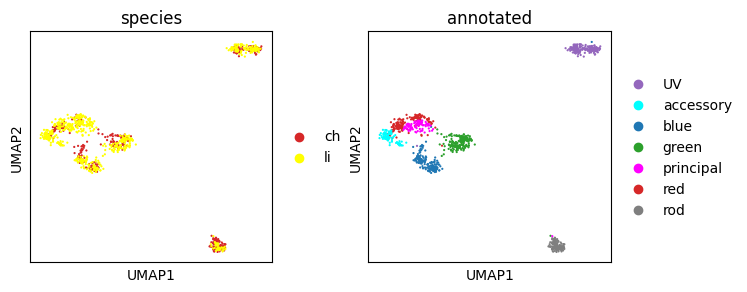

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 0.9413142522176107 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

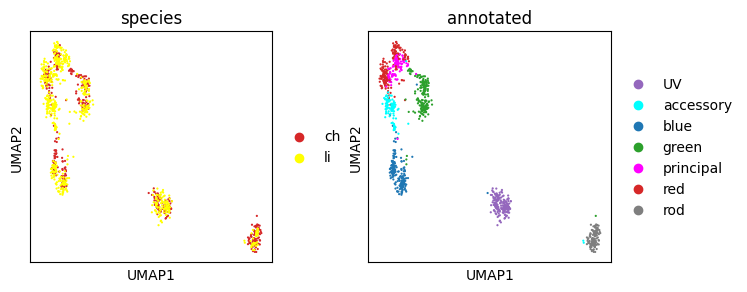

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 0.8270536343256633 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

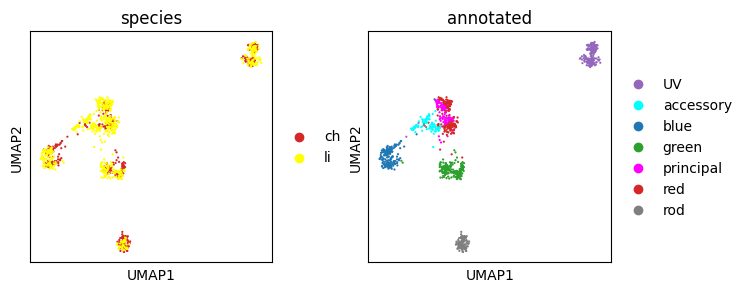

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.


In [19]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(chli_swapch, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        chli_swapch_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

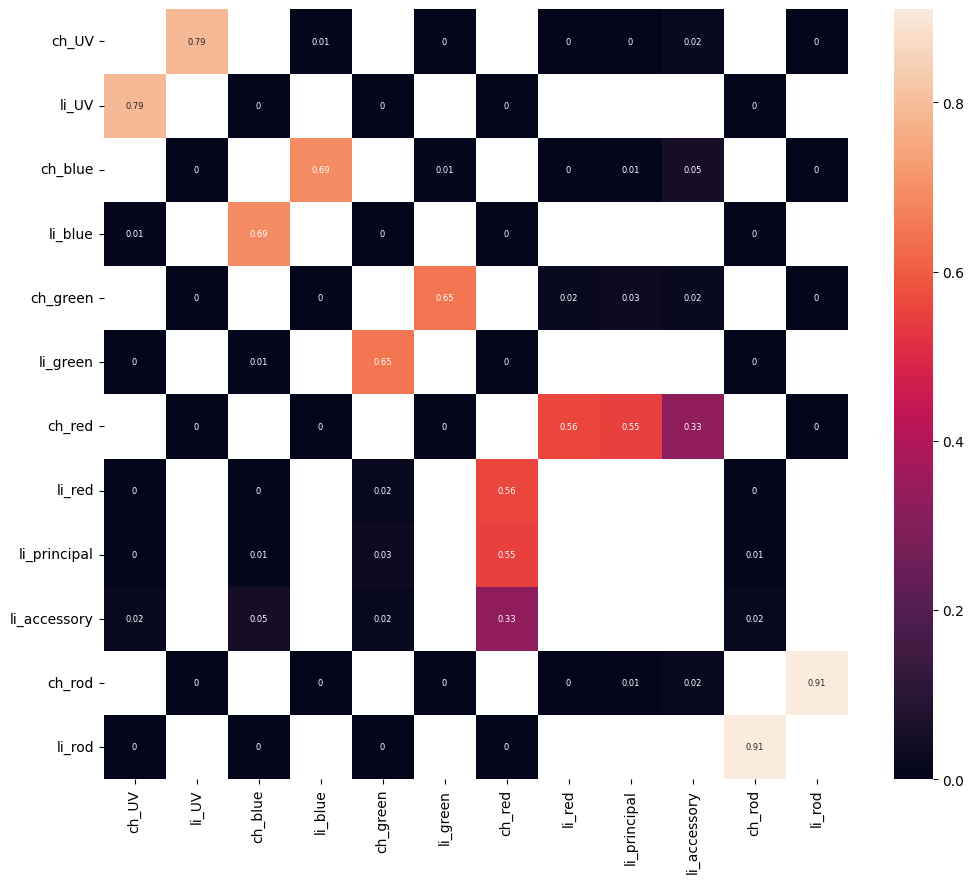

In [16]:
MeanTable(chli_swapch_res)

/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746

RUNNING SAM
Iteration: 0, Convergence: 1.0RUNNING SAM

Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746

RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0RUNNING SAM
Iteration: 0, Convergence: 1.0

RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8902354953106881
Iteration: 1, Convergence: 0.8900990920182722
Iteration: 1, Convergence: 0.8898876411737087
Iteration: 1, Convergence: 0.8916543815802616
Iteration: 1, Convergence: 0.8915014518358996
Iteration: 1, Convergence: 0.8905055254375235
Iteration: 1, Convergence: 0.890178951282264
Iteration: 1, Convergence: 0.8910670780843978
Iteration: 1, Convergence: 0.8910353882328927
Iteration: 1, Convergence: 0.8906102501887042
Iteration: 2, Convergence: 0.015447702546490196
Iteration: 2, Convergence: 0.0156340631286624
Iteration: 2, Convergence: 0.015498604328719585
Iteration: 2, Convergence: 0.014712418618234595
Iteration: 2, Convergence: 0.015430760165011497
It

Prepping datasets for translation.
Rescaling edge weights by expression correlations.
Translating feature spaces pairwise.
Prepping datasets for translation.
Prepping datasets for translation.
Translating feature spaces pairwise.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        li
ch  0.000000  0.635137
li  0.705122  0.000000
Translating feature spaces pairwise.
Projecting data into joint latent space. Prepping datasets for translation.0.7195470333099365

Translating feature spaces pairwise.
Projecting data into joint latent space. 0.7196474075317383
Running UMAP on the stitched manifolds.
Projecting data into joint latent space. 0.7205815315246582
Prepping datasets for translation.
Projecting data into joint latent space. 0.671381950378418
Prepping datasets for translation.
Correcting data with means. 0.37280964851379395
Correcting data with means. 0.5620090961456299
Translating feature spaces pairwise.
Expanding neighbourhoods of species ch...


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Correcting data with means. 0.41629624366760254


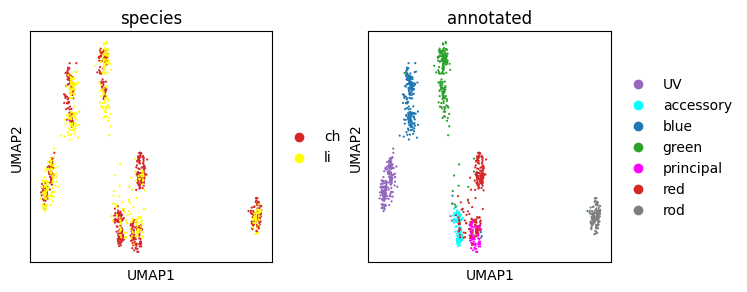

Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Finding cluster-specific markers in ch:annotated.
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        li
ch  0.000000  0.636206
li  0.698501  0.000000
Running UMAP on the stitched manifolds.
Finding cluster-specific markers in li:annotated.
Elapsed time: 1.099863306681315 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Elapsed time: 0.9481298287709554 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Elapsed time: 1.0825907667477925 minutes.Elapsed time: 0.9925283948580425 minutes.



/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

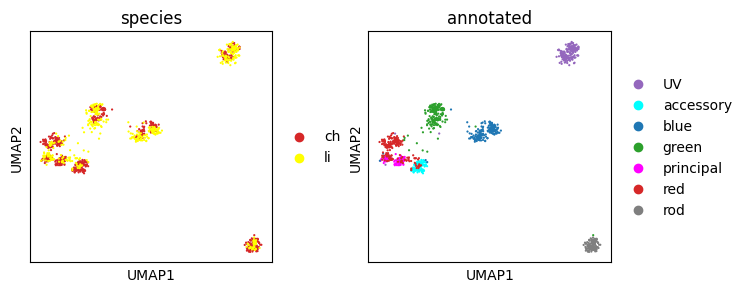

Finding cluster-specific markers in ch:annotated.


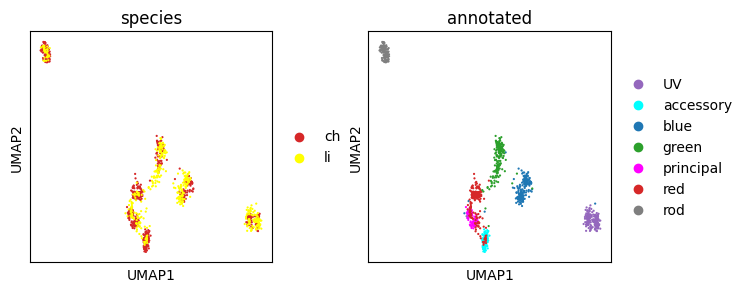

Finding cluster-specific markers in ch:annotated.


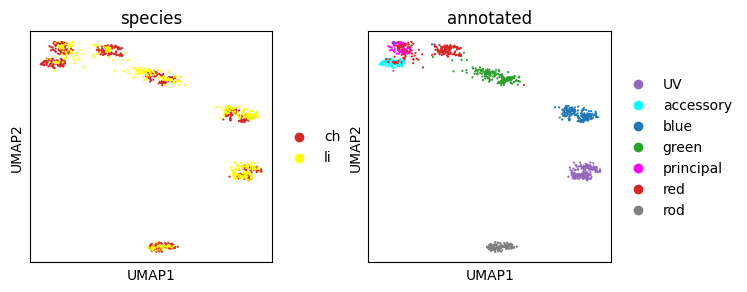

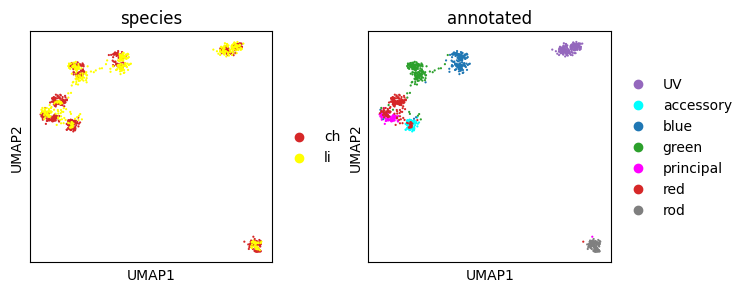

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 0.9910146435101826 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

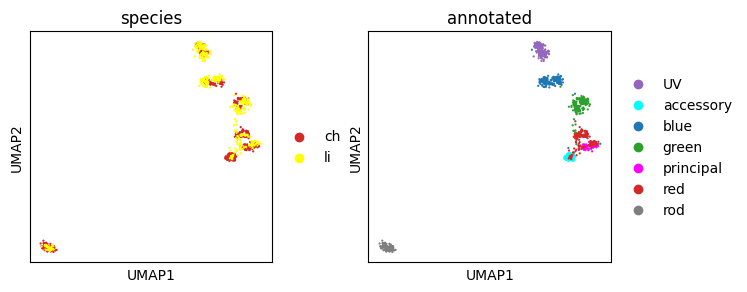

Finding cluster-specific markers in ch:annotated.
Elapsed time: 1.0023155490557352 minutes.
Elapsed time: 0.9756214539210002 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Elapsed time: 0.9836779594421386 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

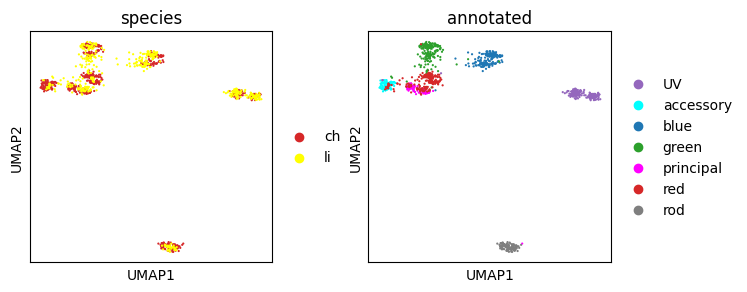

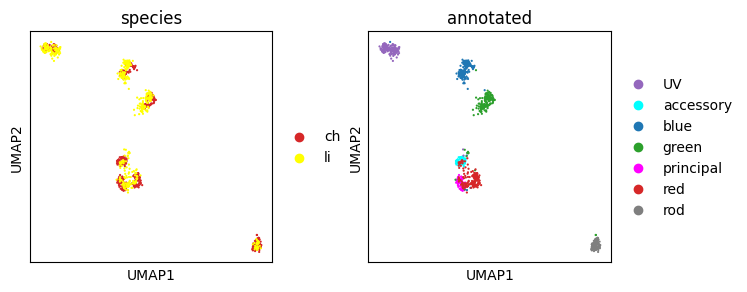

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.


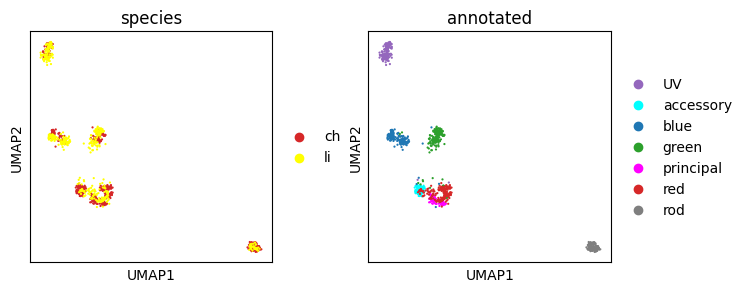

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 0.879422644774119 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

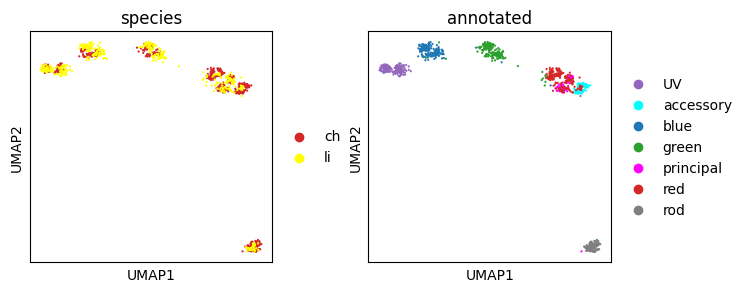

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.


In [20]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(chli_swapli, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        chli_swapli_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

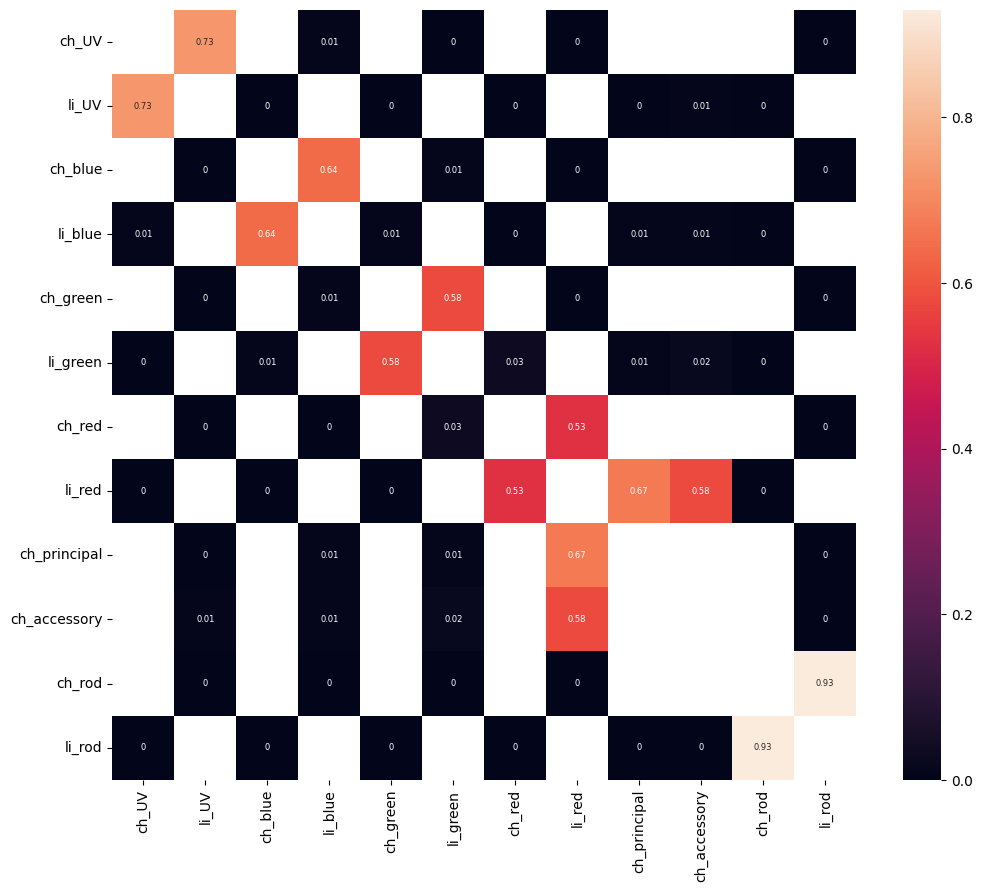

In [24]:
MeanTable(chli_swapli_res)
# StdTable(chli_swapli_res)

In [20]:
# Save tables
[chli_single_res[i][1].to_csv('MappingTable/chli_single_res_' + str(i) + '.csv') for i in range(nIter)]
[chli_double_res[i][1].to_csv('MappingTable/chli_double_res_' + str(i) + '.csv') for i in range(nIter)]
[chli_swapch_res[i][1].to_csv('MappingTable/chli_swapch_res_' + str(i) + '.csv') for i in range(nIter)]
[chli_swapli_res[i][1].to_csv('MappingTable/chli_swapli_res_' + str(i) + '.csv') for i in range(nIter)]

[None, None, None, None, None, None, None, None, None, None]

In [23]:
# save gene pairs
gpf = chli_swapch_res[1][2]
gene_pairs = gpf.find_all(align_thr=0.10)
gene_pairs.to_csv('MappingTable/chli_swapch_gene_pairs.csv')

Calculating gene pairs for the mapping: ch;UV to li;UV
Calculating gene pairs for the mapping: ch;blue to li;blue
Calculating gene pairs for the mapping: ch;green to li;green
Calculating gene pairs for the mapping: ch;red to li;accessory
Calculating gene pairs for the mapping: ch;red to li;principal
Calculating gene pairs for the mapping: ch;red to li;red
Calculating gene pairs for the mapping: ch;rod to li;rod


In [22]:
# save gene pairs
gpf = chli_swapli_res[0][2]
gene_pairs = gpf.find_all(align_thr=0.10)
gene_pairs.to_csv('MappingTable/chli_swapli_gene_pairs.csv')

Calculating gene pairs for the mapping: ch;UV to li;UV
Calculating gene pairs for the mapping: ch;accessory to li;red
Calculating gene pairs for the mapping: ch;blue to li;blue
Calculating gene pairs for the mapping: ch;green to li;green
Calculating gene pairs for the mapping: ch;principal to li;red
Calculating gene pairs for the mapping: ch;red to li;red
Calculating gene pairs for the mapping: ch;rod to li;rod


# Zebrafish, chick and lizard

In [6]:
path = '../../Species_Objects/Cone_Objects/updated/'
specieslist = ['ZebrafishAdult', 'Chicken', 'Lizard']
identlist = ['ze', 'ch', 'li']
# chli_single = dict((identlist[i], path + species + '_single.h5ad') for i, species in enumerate(specieslist))
zechli_double = dict((identlist[i], path + species + '_double.h5ad') for i, species in enumerate(specieslist))
zechli_double

{'ze': '../../Species_Objects/Cone_Objects/updated/ZebrafishAdult_double.h5ad',
 'ch': '../../Species_Objects/Cone_Objects/updated/Chicken_double.h5ad',
 'li': '../../Species_Objects/Cone_Objects/updated/Lizard_double.h5ad'}

/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746

/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_13923/1391746

RUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAM
RUNNING SAM



RUNNING SAMRUNNING SAMRUNNING SAM


Iteration: 0, Convergence: 1.0

Iteration: 0, Convergence: 1.0

Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0
Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0






Iteration: 1, Convergence: 0.936360871512124
Iteration: 1, Convergence: 0.9370027139276473Iteration: 1, Convergence: 0.9369726789764383

Iteration: 1, Convergence: 0.9373505123432739Iteration: 1, Convergence: 0.936770800565559

Iteration: 1, Convergence: 0.9363034889741297
Iteration: 2, Convergence: 0.0187520767759621
Iteration: 2, Convergence: 0.018863863837458514
Iteration: 1, Convergence: 0.9363821222877017
Iteration: 2, Convergence: 0.017393444815471403
Iteration: 1, Convergence: 0.9371355414019873
Iteration: 1, Convergence: 0.9355004853544219
Iteration: 2, Co

Alignment scores:
          ch        li        ze
ch  0.000000  0.701849  0.712414
li  0.700521  0.000000  0.622506
ze  0.818417  0.701913  0.000000
Calculating gene-gene correlations in the homology graph...
Correcting data with means. 1.6862211227416992
Rescaling edge weights by expression correlations.
Translating feature spaces pairwise.
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...Prepping datasets for translation.
Indegree coarseningPrepping datasets for translation.

Rescaling edge weights by expression correlations.

Translating feature spaces pairwise.
Translating feature spaces pairwise.
Rescaling edge weights by expression correlations.
Concatenating SAM objects...Prepping datasets for translation.

Projecting data into joint latent space. 1.28757905960083
Iteration 2 complete.
Alignment scores:
          ch        li        ze
ch  0.000000  0.699676  0.693089
li  0.713110  0.000000  0.637381
ze

ze  0.836852  0.699095  0.000000
Correcting data with means. 1.9690868854522705
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Indegree coarsening
Running UMAP on the stitched manifolds.
Rescaling edge weights by expression correlations.
Rescaling edge weights by expression correlations.
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Correcting data with means. 1.8023252487182617
Prepping datasets for translation.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        li        ze
ch  0.000000  0.713984  0.735794
li  0.719527  0.000000  0.671486
ze  0.827261  0.772025  0.000000
Iteration 3 complete.
Alignment scores:
          ch        li        ze
ch  0.000000  0.720901  0.728859
li  0.715625  0.0

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ig

Elapsed time: 1.9310686469078064 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

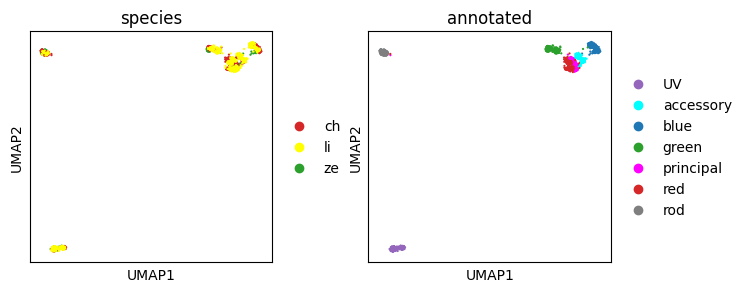

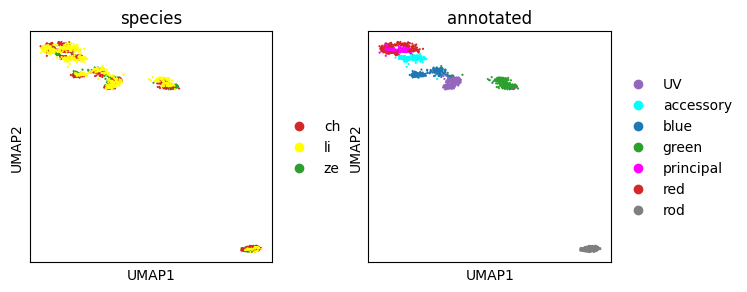

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.


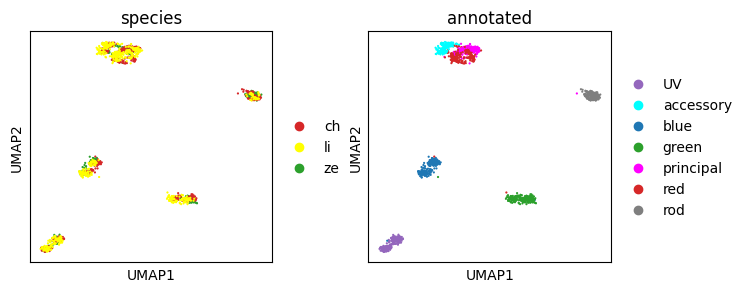

Finding cluster-specific markers in ze:annotated.
Elapsed time: 1.7649531761805217 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

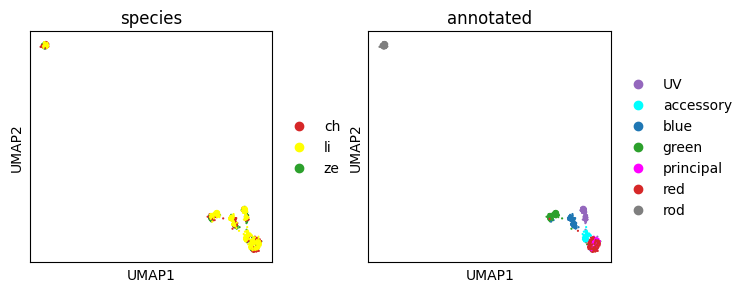

Finding cluster-specific markers in ze:annotated.
Elapsed time: 1.7976872762044271 minutes.
Elapsed time: 1.78376810948054 minutes.
Elapsed time: 1.6517273346583048 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in ch:annotated.

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))



Finding cluster-specific markers in ch:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in ch:annotated.


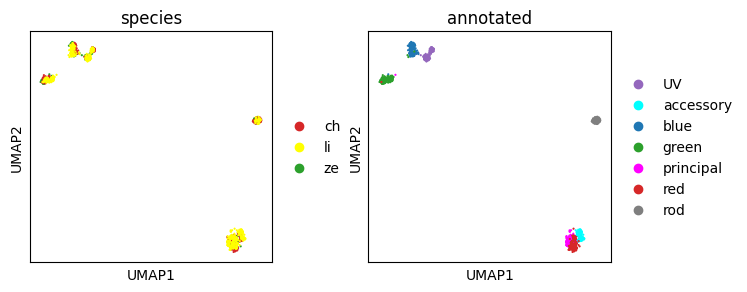

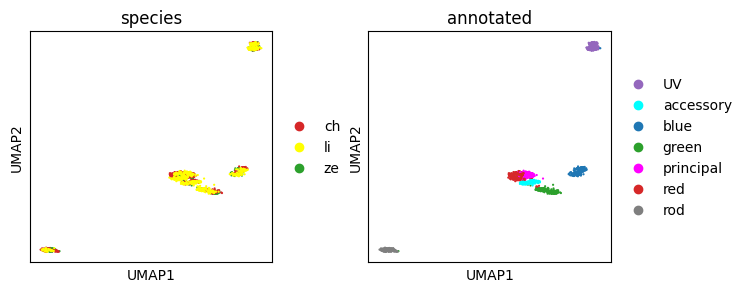

Finding cluster-specific markers in ze:annotated.


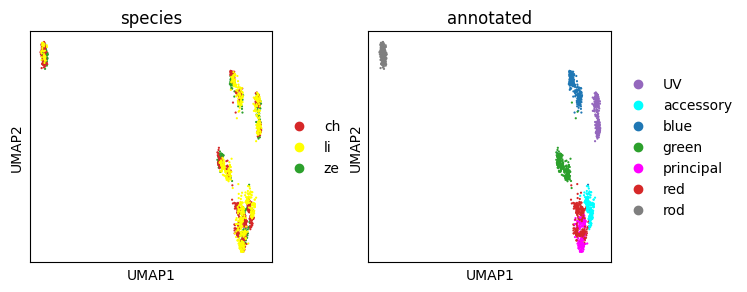

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 1.6414804657300313 minutes.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.


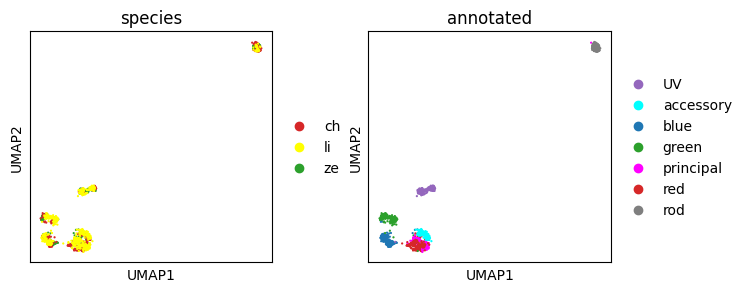

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 1.637198523680369 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

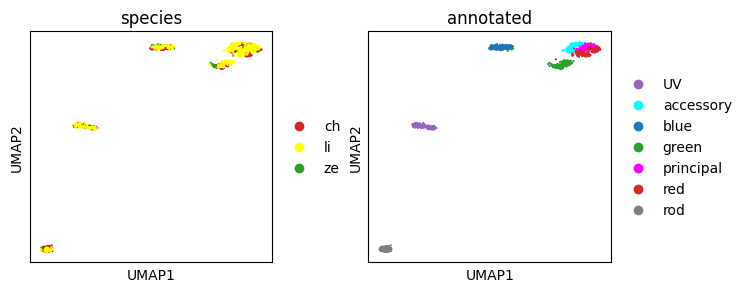

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 1.4476025104522705 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

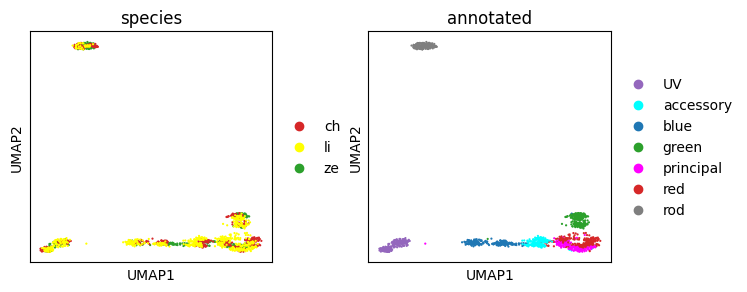

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.


In [7]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(zechli_double, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        zechli_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

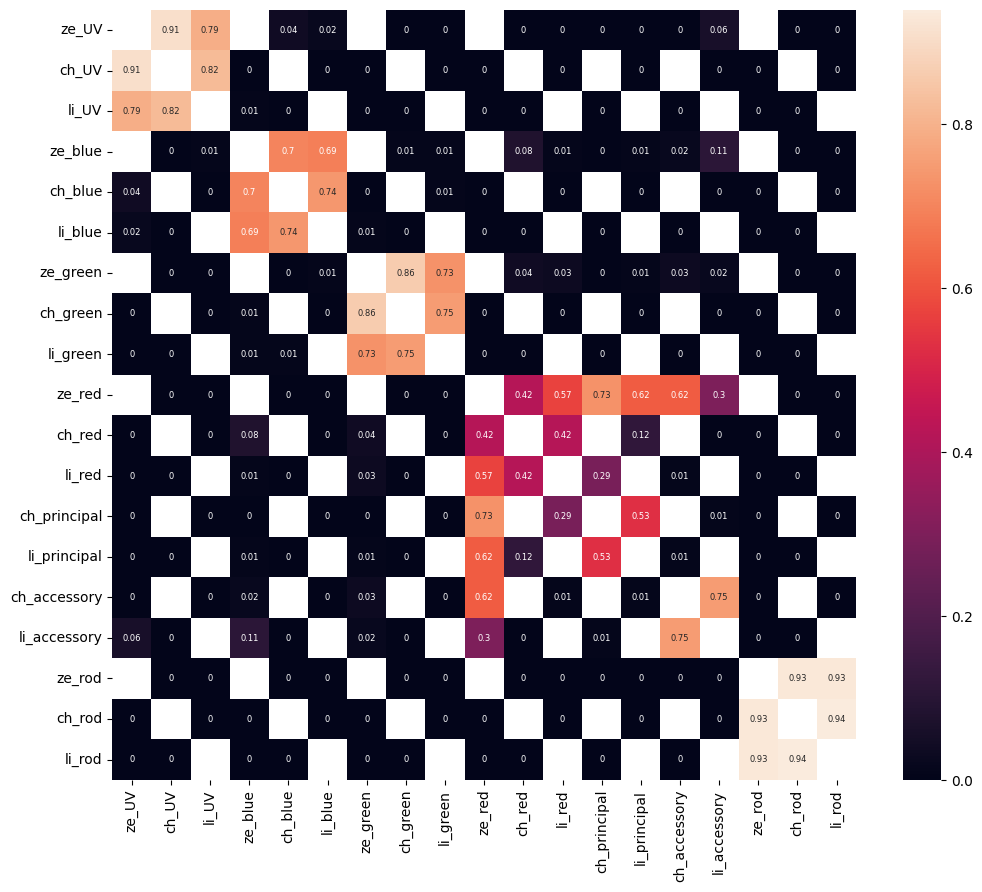

In [17]:
MeanTable(zechli_res)
# PlotHeatmap(zechli_res[0][1])


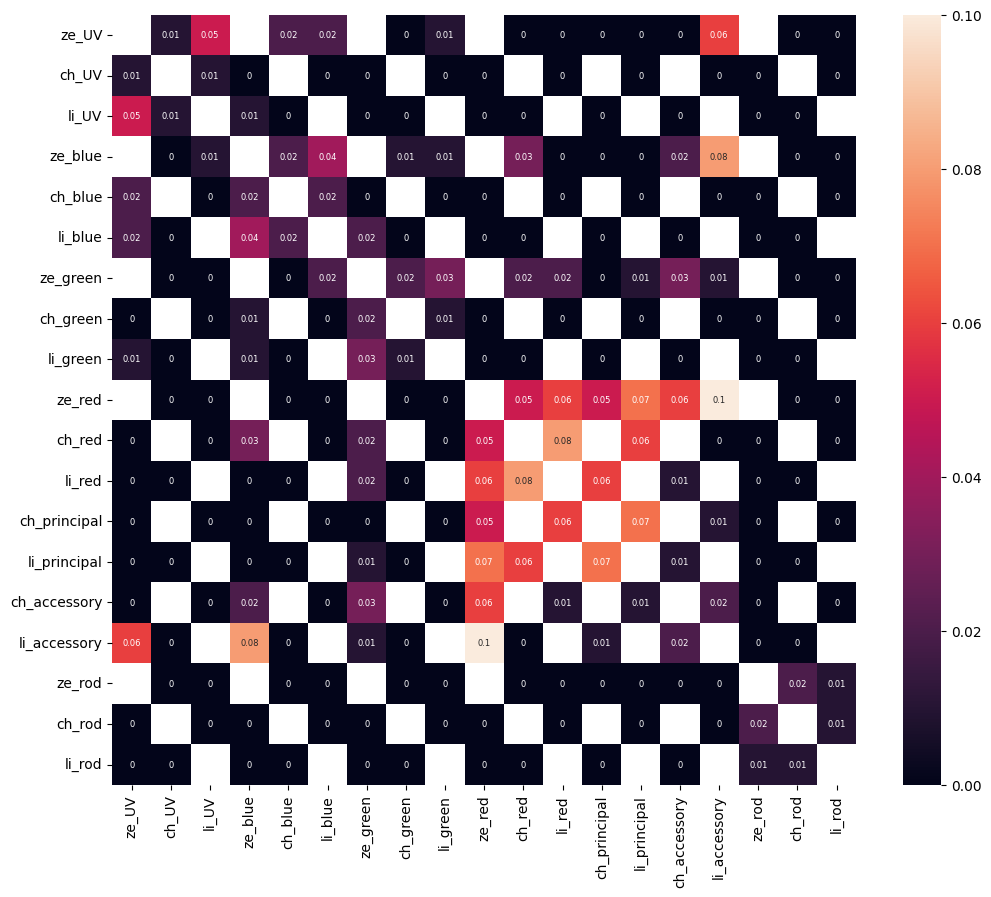

In [9]:
StdTable(zechli_res)

In [6]:
# Save tables
[zechli_res[i][1].to_csv('MappingTable/zechli_double_' + str(i) + '.csv') for i in range(nIter)]

[None, None, None, None, None, None, None, None, None, None]

In [27]:
zechli_res[0][0].query_gene_pairs('ch_CALB1')
zechli_res[1][0].query_gene_pairs('ch_CALB1')

{'blast': ze_calb2b    297.0
 ze_calb1     379.0
 ze_scgn      184.0
 ze_calb2a    318.0
 li_SCGN      179.0
 li_CALB1     466.0
 li_CALB2     323.0
 dtype: float64,
 'correlation': li_CALB1    0.529924
 dtype: float64}

In [25]:
# gene pairs
gpf = zechli_res[0][2]
gene_pairs = gpf.find_all(align_thr=0.10)
gene_pairs.to_csv('MappingTable/zechli_gene_pairs_0.csv')

Calculating gene pairs for the mapping: ch;UV to li;UV
Calculating gene pairs for the mapping: ch;UV to ze;UV
Calculating gene pairs for the mapping: ch;accessory to li;accessory
Calculating gene pairs for the mapping: ch;accessory to ze;red
Calculating gene pairs for the mapping: ch;blue to li;blue
Calculating gene pairs for the mapping: ch;blue to ze;blue
Calculating gene pairs for the mapping: ch;green to li;green
Calculating gene pairs for the mapping: ch;green to ze;green
Calculating gene pairs for the mapping: ch;principal to li;principal
Calculating gene pairs for the mapping: ch;principal to li;red
Calculating gene pairs for the mapping: ch;principal to ze;red
Calculating gene pairs for the mapping: ch;red to li;red
Calculating gene pairs for the mapping: ch;red to ze;blue
Calculating gene pairs for the mapping: ch;red to ze;red
Calculating gene pairs for the mapping: ch;rod to li;rod
Calculating gene pairs for the mapping: ch;rod to ze;rod
Calculating gene pairs for the mappin

In [24]:
# gene pairs
gpf = zechli_res[1][2]
gene_pairs = gpf.find_all(align_thr=0.10)
gene_pairs.to_csv('MappingTable/zechli_gene_pairs_1.csv')

Calculating gene pairs for the mapping: ch;UV to li;UV
Calculating gene pairs for the mapping: ch;UV to ze;UV
Calculating gene pairs for the mapping: ch;accessory to li;accessory
Calculating gene pairs for the mapping: ch;accessory to ze;red
Calculating gene pairs for the mapping: ch;blue to li;blue
Calculating gene pairs for the mapping: ch;blue to ze;blue
Calculating gene pairs for the mapping: ch;green to li;green
Calculating gene pairs for the mapping: ch;green to ze;green
Calculating gene pairs for the mapping: ch;principal to li;principal
Calculating gene pairs for the mapping: ch;principal to li;red
Calculating gene pairs for the mapping: ch;principal to ze;red
Calculating gene pairs for the mapping: ch;red to li;red
Calculating gene pairs for the mapping: ch;red to ze;red
Calculating gene pairs for the mapping: ch;rod to li;rod
Calculating gene pairs for the mapping: ch;rod to ze;rod
Calculating gene pairs for the mapping: li;UV to ze;UV
Calculating gene pairs for the mapping: 

# Add human

In [12]:
path = '../../Species_Objects/Cone_Objects/updated/'
specieslist = ['ZebrafishAdult', 'Chicken', 'Lizard', 'Human']
identlist = ['ze', 'ch', 'li', 'hs']
# chli_single = dict((identlist[i], path + species + '_single.h5ad') for i, species in enumerate(specieslist))
zechlihs_double = dict((identlist[i], path + species + '_double.h5ad') for i, species in enumerate(specieslist))
zechlihs_double

{'ze': '../../Species_Objects/Cone_Objects/updated/ZebrafishAdult_double.h5ad',
 'ch': '../../Species_Objects/Cone_Objects/updated/Chicken_double.h5ad',
 'li': '../../Species_Objects/Cone_Objects/updated/Lizard_double.h5ad',
 'hs': '../../Species_Objects/Cone_Objects/updated/Human_double.h5ad'}

/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:1

/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:1

RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAMRUNNING SAMRUNNING SAM


Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0




/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.936360871512124
Iteration: 1, Convergence: 0.9369726789764383
Iteration: 1, Convergence: 0.9363821222877017
Iteration: 1, Convergence: 0.9355026297705117
Iteration: 1, Convergence: 0.9364806246086416
Iteration: 1, Convergence: 0.9373505123432739
Iteration: 1, Convergence: 0.936770800565559
Iteration: 1, Convergence: 0.9371355414019873
Iteration: 1, Convergence: 0.9363033024102153
Iteration: 1, Convergence: 0.9370027139276473
Iteration: 2, Convergence: 0.01617470979572506
Iteration: 2, Convergence: 0.018216450573094855
Iteration: 2, Convergence: 0.017393444815471403
Iteration: 2, Convergence: 0.020066394099364726
Iteration: 2, Convergence: 0.0187520767759621
Iteration: 2, Convergence: 0.017447487972667087
Iteration: 2, Convergence: 0.016988420184651194
Iteration: 2, Convergence: 0.01900123122366594
Iteration: 2, Convergence: 0.018863863837458514
Iteration: 2, Convergence: 0

Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species hs...
Indegree coarsening
Correcting data with means. 3.374068021774292
Translating feature spaces pairwise.
Concatenating SAM objects...
Rescaling edge weights by expression correlations.
Iteration 1 complete.
Alignment scores:
          ch        hs        li        ze
ch  0.000000  0.461582  0.535354  0.573412
hs  0.547648  0.000000  0.490804  0.624727
li  0.540796  0.409806  0.000000  0.500240
ze  0.667835  0.565752  0.522628  0.000000
Calculating gene-gene correlations in the homology graph...
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species hs...
Indegree coarsening
Concatenating SAM objects...
Iteration 1 complete.
Alignment scores:
          ch        hs        li        ze
ch  0.000000  0.450247  0.533517  

Correcting data with means. 2.0486133098602295
Iteration 3 complete.
Alignment scores:
          ch        hs        li        ze
ch  0.000000  0.539467  0.718278  0.763728
hs  0.722486  0.000000  0.628782  0.792443
li  0.718150  0.475282  0.000000  0.692287
ze  0.850212  0.595795  0.741460  0.000000
Running UMAP on the stitched manifolds.
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species hs...
Indegree coarsening
Prepping datasets for translation.
Translating feature spaces pairwise.
Rescaling edge weights by expression correlations.
Projecting data into joint latent space. 1.537081003189087
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        hs        li        ze
ch  0.000000  0.547789  0.708656  0.762685
hs  0.734606  0.000000  0.626746  0.799836
li  0.707732  0.459866  0.000000  0.636818
ze  0.869637  0.617941  0.705095  0.000000
Runn

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

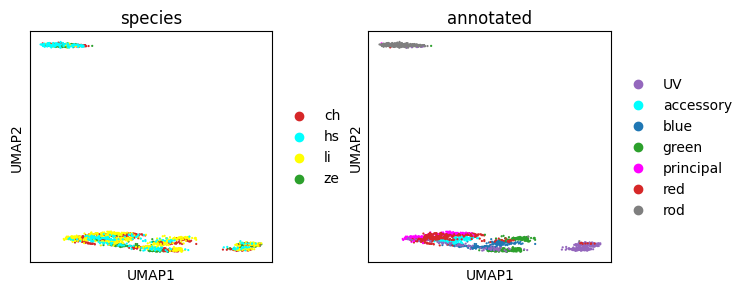

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 2.482787322998047 minutes.
Elapsed time: 2.2983034372329714 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.


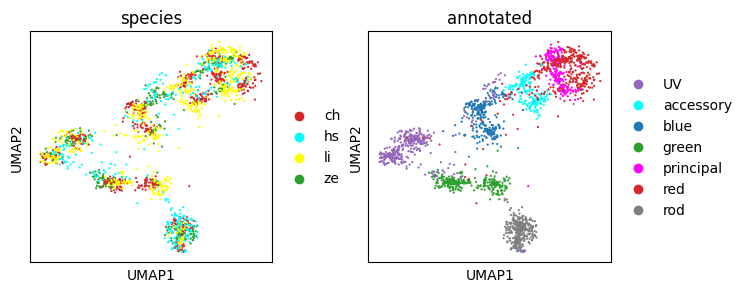

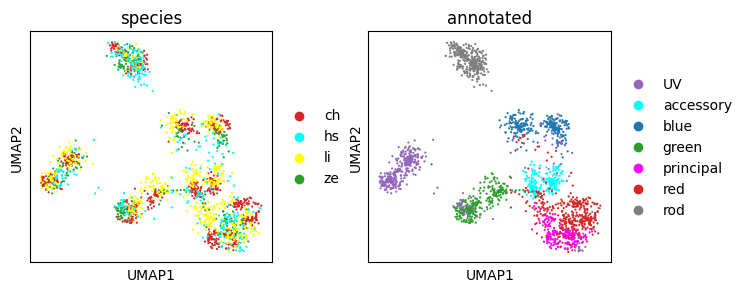

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 2.273384431997935 minutes.
Elapsed time: 2.3496532758076984 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.


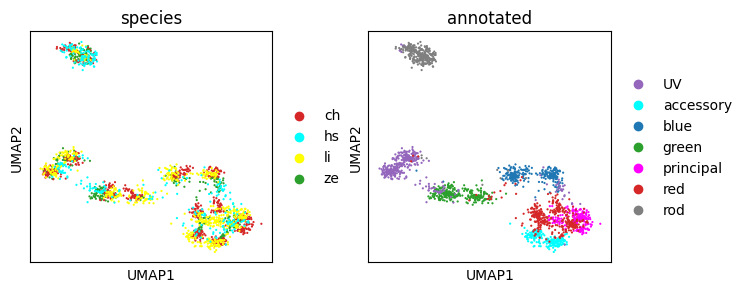

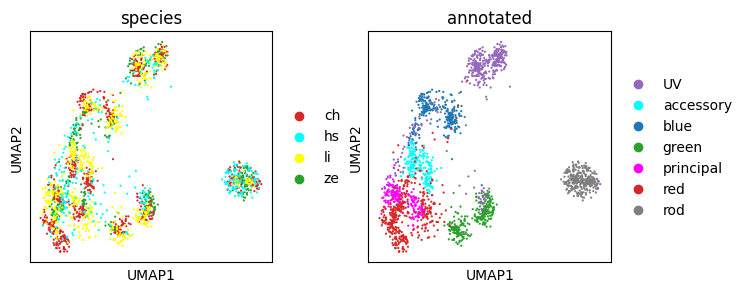

Elapsed time: 2.5523459474245707 minutes.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

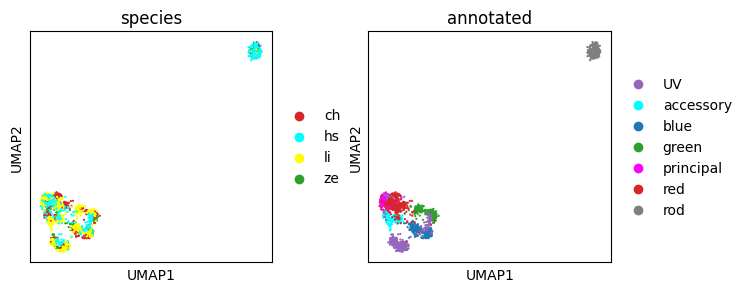

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 2.4273138483365377 minutes.



/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in li:annotated.

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.


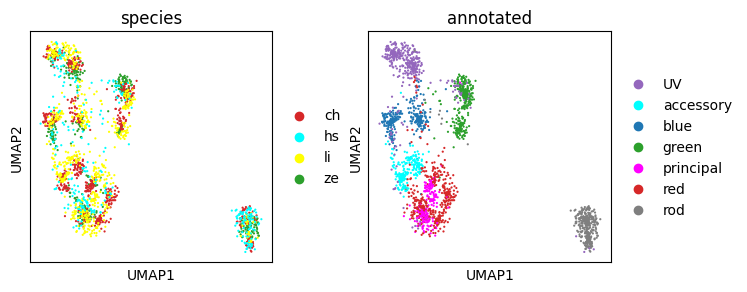

Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 2.2785266677538556 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

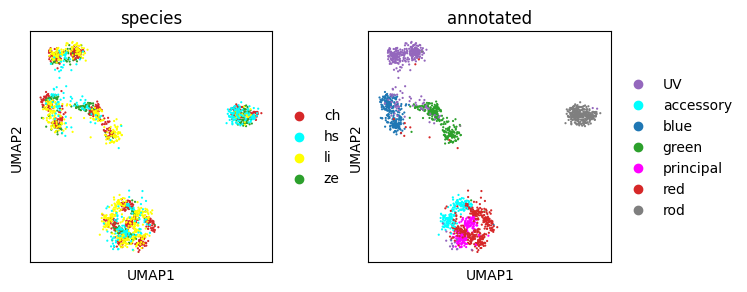

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.
Elapsed time: 2.203408630688985 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Elapsed time: 2.3860057671864827 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

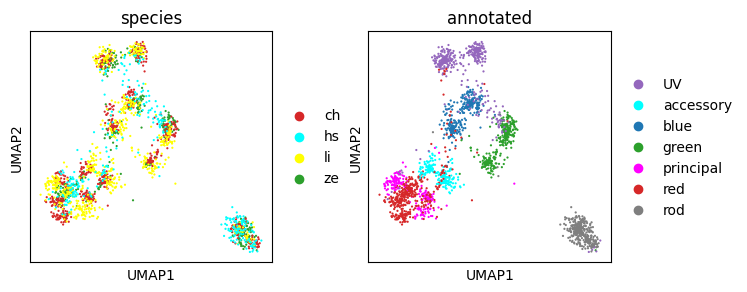

Finding cluster-specific markers in ze:annotated.


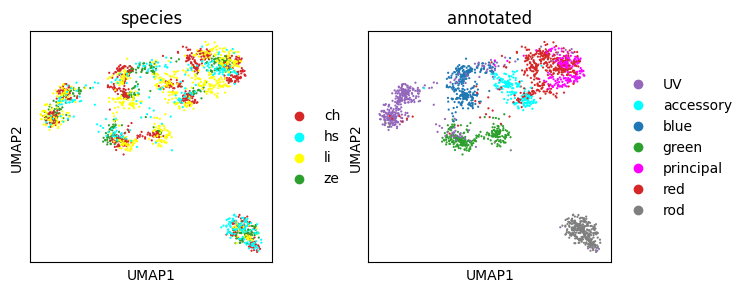

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.

Finding cluster-specific markers in li:annotated.Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.


In [14]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(zechlihs_double, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        zechlihs_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

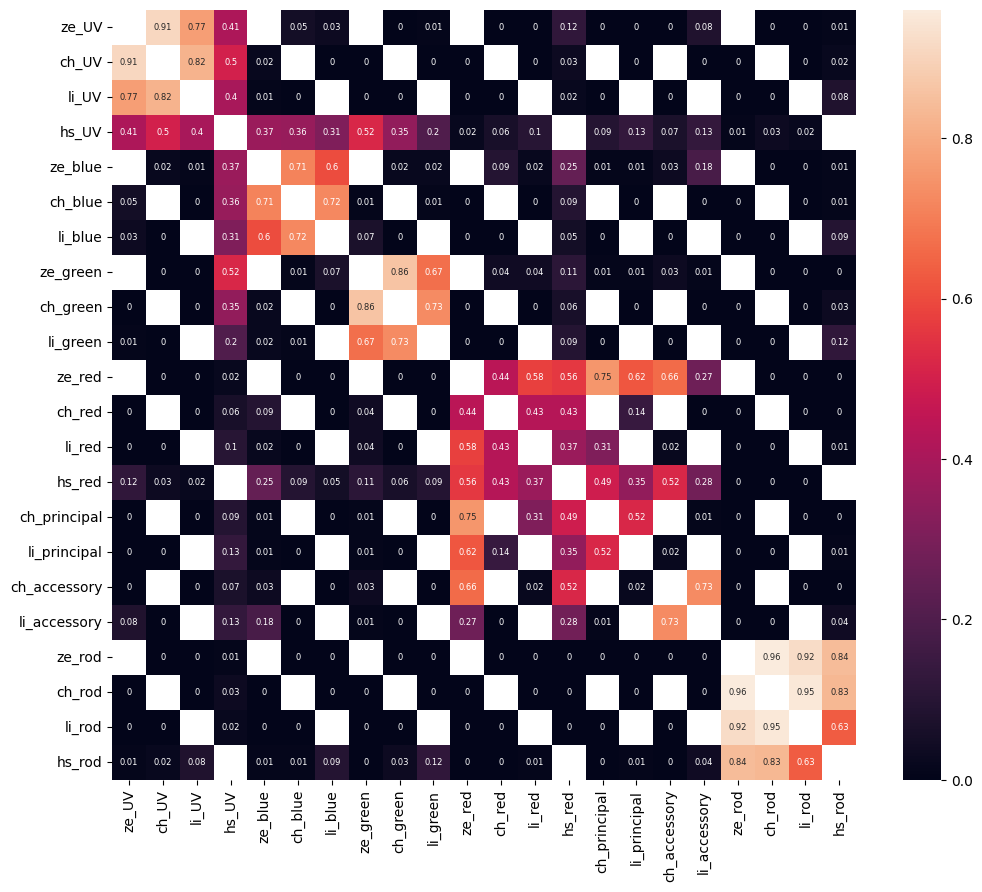

In [15]:
MeanTable(zechlihs_res)

# Add squirrel

In [16]:
path = '../../Species_Objects/Cone_Objects/updated/'
specieslist = ['ZebrafishAdult', 'Chicken', 'Lizard', 'Squirrel']
identlist = ['ze', 'ch', 'li', 'sq']
# chli_single = dict((identlist[i], path + species + '_single.h5ad') for i, species in enumerate(specieslist))
zechlisq_double = dict((identlist[i], path + species + '_double.h5ad') for i, species in enumerate(specieslist))
zechlisq_double

{'ze': '../../Species_Objects/Cone_Objects/updated/ZebrafishAdult_double.h5ad',
 'ch': '../../Species_Objects/Cone_Objects/updated/Chicken_double.h5ad',
 'li': '../../Species_Objects/Cone_Objects/updated/Lizard_double.h5ad',
 'sq': '../../Species_Objects/Cone_Objects/updated/Squirrel_double.h5ad'}

/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:1

/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_40936/31584599.py:1

RUNNING SAMRUNNING SAM

Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0

RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAMRUNNING SAMRUNNING SAM


Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0




/tmp/ipykernel_40936/31584599.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.9354994831459044
Iteration: 1, Convergence: 0.9371355414019873
Iteration: 1, Convergence: 0.9373505123432739
Iteration: 1, Convergence: 0.9364806246086416
Iteration: 1, Convergence: 0.9370027139276473
Iteration: 1, Convergence: 0.936360871512124
Iteration: 1, Convergence: 0.9369726789764383
Iteration: 1, Convergence: 0.9363034889741297
Iteration: 1, Convergence: 0.936380681516721
Iteration: 1, Convergence: 0.936770800565559
Iteration: 2, Convergence: 0.020016803291940343
Iteration: 2, Convergence: 0.018216450573094855
Iteration: 2, Convergence: 0.017393444815471403
Iteration: 2, Convergence: 0.018974379973686065
Iteration: 2, Convergence: 0.018863863837458514
Iteration: 2, Convergence: 0.01617470979572506
Iteration: 2, Convergence: 0.016988420184651194
Iteration: 2, Convergence: 0.017495003570913364
Iteration: 2, Convergence: 0.01

Alignment scores:
          ch        li        sq        ze
ch  0.000000  0.536807  0.462512  0.586667
li  0.567928  0.000000  0.444814  0.526613
sq  0.571431  0.538030  0.000000  0.622464
ze  0.676618  0.527537  0.497275  0.000000
Calculating gene-gene correlations in the homology graph...Iteration 1 complete.

Alignment scores:
Iteration 1 complete.          ch        li        sq        ze
ch  0.000000  0.553291  0.468380  0.597890
li  0.555867  0.000000  0.434715  0.515062
sq  0.561695  0.524797  0.000000  0.608608
ze  0.689655  0.534463  0.496843  0.000000

Calculating gene-gene correlations in the homology graph...
Alignment scores:
Iteration 1 complete.Iteration 1 complete.

Alignment scores:Iteration 1 complete.Alignment scores:
          ch        li        sq        ze
ch  0.000000  0.548314  0.467128  0.581282
li  0.568709  0.000000  0.442800  0.532370
sq  0.570833  0.537167  0.000000  0.617256
ze  0.653443  0.530011  0.487150  0.000000


Alignment scores:Calculating gene-g

Alignment scores:
          ch        li        sq        ze
ch  0.000000  0.752371  0.607997  0.782994
li  0.744393  0.000000  0.555284  0.703850
sq  0.769140  0.724397  0.000000  0.812974
ze  0.862043  0.794651  0.645120  0.000000
Running UMAP on the stitched manifolds.
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species sq...
Indegree coarsening
Running UMAP on the stitched manifolds.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        li        sq        ze
ch  0.000000  0.746796  0.600517  0.783051
li  0.745372  0.000000  0.550468  0.726784
sq  0.751881  0.705663  0.000000  0.800737
ze  0.887936  0.787841  0.648924  0.000000
Rescaling edge weights by expression correlations.
Running UMAP on the stitched manifolds.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        li        sq        ze
ch  0.000000

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Elapsed time: 5.477613627910614 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Elapsed time: 5.262842233975729 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

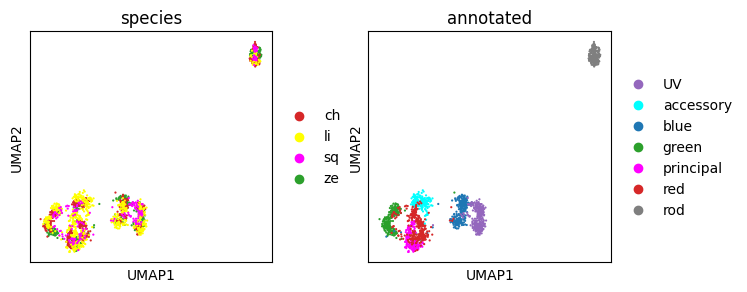

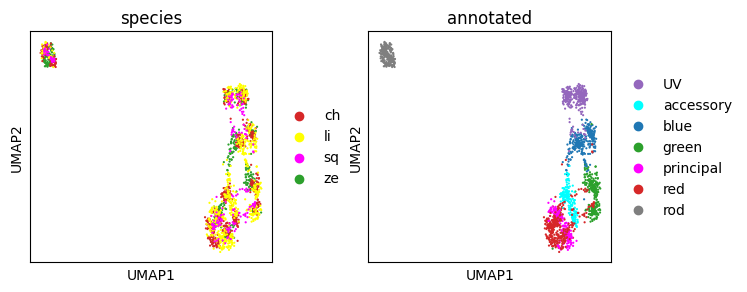

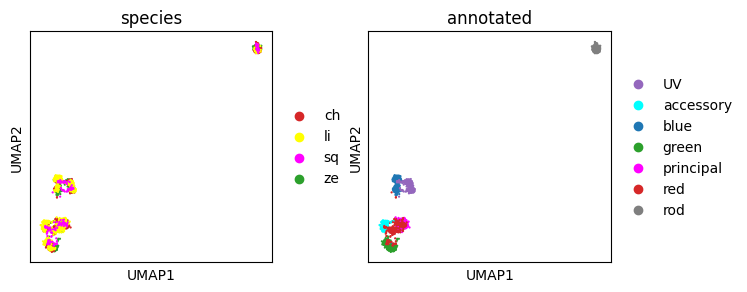

Finding cluster-specific markers in ze:annotated.
Elapsed time: 5.44806059996287 minutes.


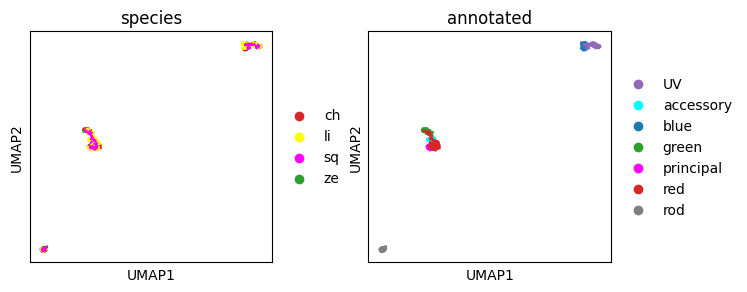

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Elapsed time: 5.746783912181854 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the

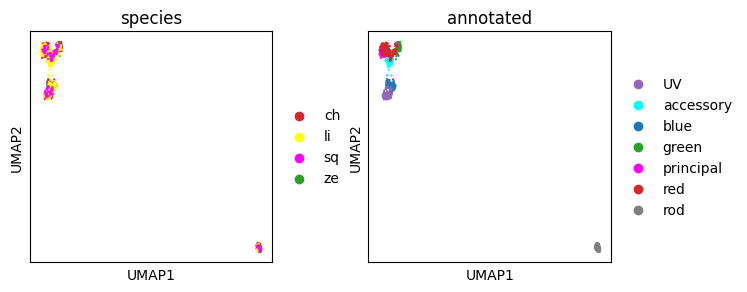

Finding cluster-specific markers in ze:annotated.


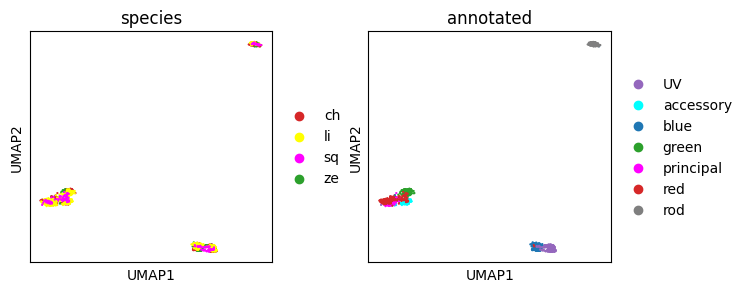

Finding cluster-specific markers in ze:annotated.
Elapsed time: 5.370499920845032 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

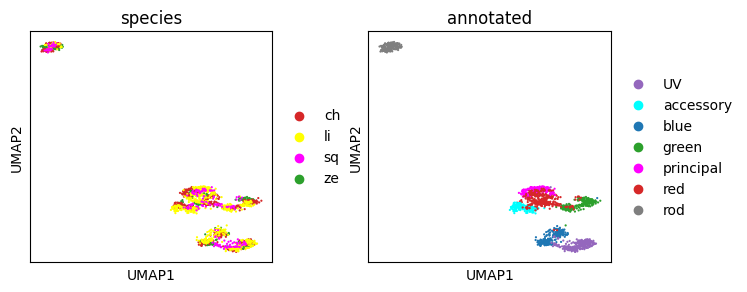

Finding cluster-specific markers in ze:annotated.
Elapsed time: 5.340641963481903 minutes.
Elapsed time: 5.370209503173828 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

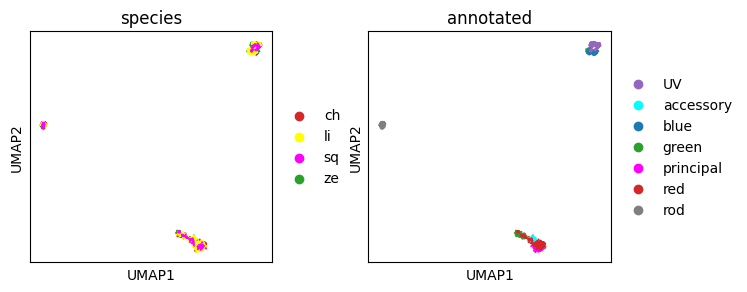

Finding cluster-specific markers in ze:annotated.


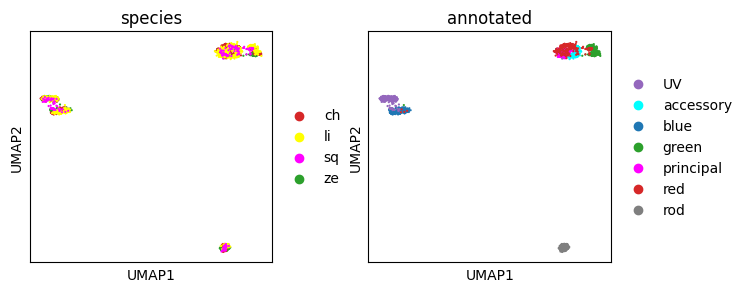

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.Finding cluster-specific markers in ch:annotated.Finding cluster-specific markers in ch:annotated.


Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.Finding cluster-specific markers in li:annotated.

Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 5.587553520997365 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in li:annotated.


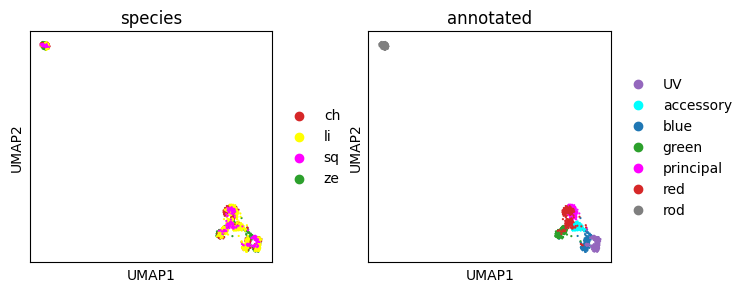

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in sq:annotated.Finding cluster-specific markers in sq:annotated.

Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in sq:annotated.


In [17]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(zechlisq_double, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        zechlisq_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

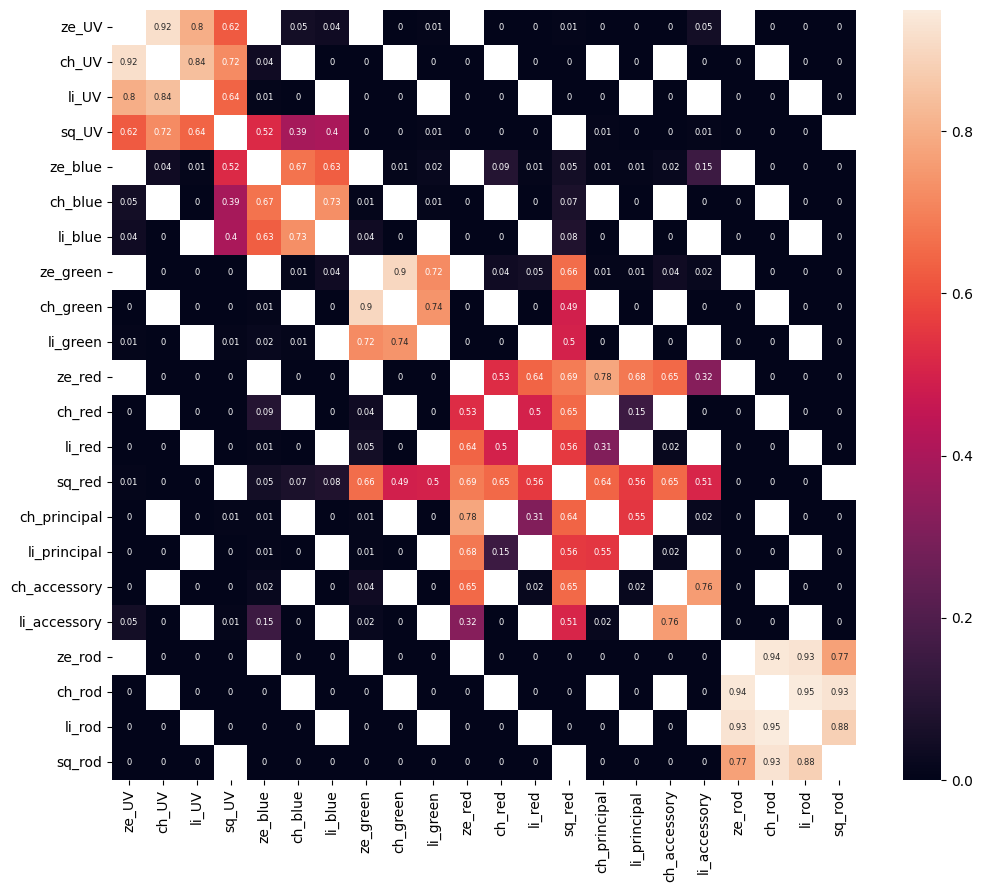

In [18]:
MeanTable(zechlisq_res)

In [19]:
# gene pairs
gpf = zechlisq_res[0][2]
gene_pairs = gpf.find_all(align_thr=0.10)
gene_pairs

Calculating gene pairs for the mapping: ch;UV to li;UV
Calculating gene pairs for the mapping: ch;UV to sq;UV
Calculating gene pairs for the mapping: ch;UV to ze;UV
Calculating gene pairs for the mapping: ch;accessory to li;accessory
Calculating gene pairs for the mapping: ch;accessory to sq;red
Calculating gene pairs for the mapping: ch;accessory to ze;red
Calculating gene pairs for the mapping: ch;blue to li;blue
Calculating gene pairs for the mapping: ch;blue to sq;UV
Calculating gene pairs for the mapping: ch;blue to ze;blue
Calculating gene pairs for the mapping: ch;green to li;green
Calculating gene pairs for the mapping: ch;green to sq;red
Calculating gene pairs for the mapping: ch;green to ze;green
Calculating gene pairs for the mapping: ch;principal to li;principal
Calculating gene pairs for the mapping: ch;principal to li;red
Calculating gene pairs for the mapping: ch;principal to sq;red
Calculating gene pairs for the mapping: ch;principal to ze;red
Calculating gene pairs for

ch_UV;li_UV ch_UV;li_UV_pval1 ch_UV;li_UV_pval2  \
0           ch_NRXN3;li_NRXN3               0.0               0.0   
1         ch_OPN1SW;li_OPN1SW               0.0               0.0   
2       ch_PCDH11X;li_PCDH11X               0.0               0.0   
3             ch_TBX2;li_TBX2               0.0               0.0   
4            ch_FABP5;li_RBP1               0.0          0.000016   
5            ch_CDH12;li_CDH7               0.0          0.000365   
6             ch_FAT1;li_FAT1          0.000772               0.0   
7           ch_PTPRS;li_PTPRD               0.0               0.0   
8             ch_DCX;li_DCLK1               0.0          0.000001   
9             ch_NEBL;li_NEBL               0.0          0.000285   
10          ch_DCLK2;li_DCLK1               0.0          0.000001   
11            ch_NAV2;li_NAV2               0.0          0.002944   
12          ch_MAGI1;li_MAGI1          0.008177               0.0   
13        ch_FAM19A2;li_TAFA3          0.007756          0.000001   
14        ch_LHFPL4;li_LHFPL3          0.000161          0.000063   
15  ch_LOC101749175;li_LHFPL3          0.003929          0.000063   
16              ch_BSG;li_BSG          0.006194          0.004325   
17                        NaN               NaN               NaN   
18                        NaN               NaN               NaN   
19                        NaN               NaN               NaN   
20                        NaN               NaN               NaN   
21                        NaN               NaN               NaN   
22                        NaN               NaN               NaN   
23                        NaN               NaN               NaN   
24                        NaN               NaN               NaN   
25                        NaN               NaN               NaN   
26                        NaN               NaN               NaN   
27                        NaN               NaN               NaN   
28                        NaN               NaN               NaN   
29                        NaN               NaN               NaN   
30                        NaN               NaN               NaN   
31                        NaN               NaN               NaN   
32                        NaN               NaN               NaN   
33                        NaN               NaN               NaN   
34                        NaN               NaN               NaN   
35                        NaN               NaN               NaN   
36                        NaN               NaN               NaN   
37                        NaN               NaN               NaN   
38                        NaN               NaN               NaN   
39                        NaN               NaN               NaN   
40                        NaN               NaN               NaN   
41                        NaN               NaN               NaN   
42                        NaN               NaN               NaN   
43                        NaN               NaN               NaN   
44                        NaN               NaN               NaN   
45                        NaN               NaN               NaN   
46                        NaN               NaN               NaN   
47                        NaN               NaN               NaN   
48                        NaN               NaN               NaN   
49                        NaN               NaN               NaN   
50                        NaN               NaN               NaN   
51                        NaN               NaN               NaN   
52                        NaN               NaN               NaN   
53                        NaN               NaN               NaN   
54                        NaN               NaN               NaN   
55                        NaN               NaN               NaN   
56                        NaN               NaN               NaN   
57              

In [20]:
zechlisq_res[0][0].query_gene_pairs('sq_ENSSTOG00000024701')

{'blast': ze_opn1sw1              308.00
 ze_opn4xb               153.50
 ze_tmtops2a             160.00
 ze_opn1mw1              282.00
 ze_opn1mw2              272.50
 ze_opn1mw3              284.50
 ze_opn1mw4              288.50
 ze_opn4.1               143.00
 ze_CABZ01063651.1       113.50
 ze_tmtops2b             159.00
 ze_opn9                  85.50
 ze_opn8b                107.00
 ze_taar15                63.20
 ze_opn8c                100.00
 ze_opn8a                105.00
 ze_opn7c                103.00
 ze_opn7d                100.10
 ze_rho                  277.50
 ze_exorh                121.00
 ze_parapinopsina        237.00
 ze_opn6b                109.00
 ze_tmtops3a             166.00
 ze_opn3                 145.00
 ze_FO904836.1            65.10
 ze_CU570800.2            67.55
 ze_CU570800.4            62.00
 ze_valopa               277.00
 ze_CU570800.3            64.30
 ze_BX324188.1            58.90
 ze_valopb               268.00
 ze_si:dkey-211g8.1       63.55

# With double cones

/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949

/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949

/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_23081/2154949

RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0RUNNING SAM

Iteration: 0, Convergence: 1.0RUNNING SAM

Iteration: 0, Convergence: 1.0
RUNNING SAMRUNNING SAM

Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0

RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_23081/2154949592.py:114: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.936360871512124
Iteration: 1, Convergence: 0.9373505123432739
Iteration: 1, Convergence: 0.9370027139276473Iteration: 1, Convergence: 0.9369726789764383

Iteration: 1, Convergence: 0.9364806246086416
Iteration: 1, Convergence: 0.936770800565559
Iteration: 1, Convergence: 0.9355004853544219
Iteration: 1, Convergence: 0.9363855809612455
Iteration: 1, Convergence: 0.9371355414019873
Iteration: 2, Convergence: 0.0187520767759621
Iteration: 2, Convergence: 0.02001499390748769
Iteration: 2, Convergence: 0.017495003570913364
Iteration: 1, Convergence: 0.9363034889741297
Iteration: 2, Convergence: 0.016988420184651194
Iteration: 2, Convergence: 0.018216450573094855
Iteration: 2, Convergence: 0.018863863837458514
Iteration: 2, Convergence: 0.017393444815471403
Iteration: 2, Convergence: 0.01744396937026417
Iteration: 2, Convergence: 0.01617470979572506
Elapsed time: 13.123029708862305 seconds
Elapsed time: 13.15204000473022

16325 `ch` gene symbols match between the datasets and the BLAST graph.
19644 `li` gene symbols match between the datasets and the BLAST graph.
23228 `ze` gene symbols match between the datasets and the BLAST graph.
21009 `op` gene symbols match between the datasets and the BLAST graph.
16325 `ch` gene symbols match between the datasets and the BLAST graph.
17385 `sq` gene symbols match between the datasets and the BLAST graph.
19644 `li` gene symbols match between the datasets and the BLAST graph.
19379 `hs` gene symbols match between the datasets and the BLAST graph.
21009 `op` gene symbols match between the datasets and the BLAST graph.
17385 `sq` gene symbols match between the datasets and the BLAST graph.
Prepping datasets for translation.
19379 `hs` gene symbols match between the datasets and the BLAST graph.
23228 `ze` gene symbols match between the datasets and the BLAST graph.
Translating feature spaces pairwise.
16325 `ch` gene symbols match between the datasets and the BLAST

Rescaling edge weights by expression correlations.
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species op...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Concatenating SAM objects...
Correcting data with means. Rescaling edge weights by expression correlations.
6.4815778732299805
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species op...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species hs...
Expanding neighbourhoods of species ch...
Indegree coarsening
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species op...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Iterat

Expanding neighbourhoods of species hs...
Indegree coarsening
Correcting data with means. 4.518083810806274
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species op...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Rescaling edge weights by expression correlations.
Rescaling edge weights by expression correlations.
Rescaling edge weights by expression correlations.
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species op...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Projecting data into joint latent space. 7.2075583934783936Concatenating SAM objects...

Iteration 3 complete.
Alignment scores:
          ch        hs        li        op        sq        ze
ch 

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Elapsed time: 4.257635577519735 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the

Elapsed time: 4.237716841697693 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

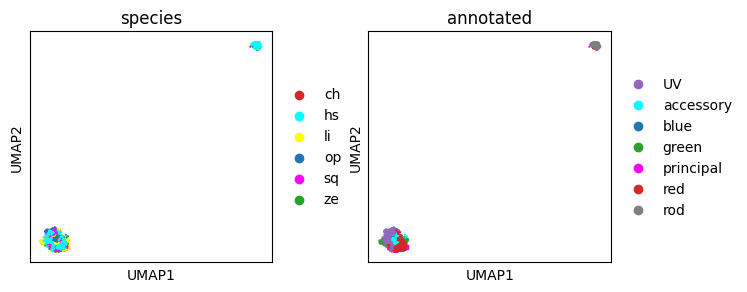

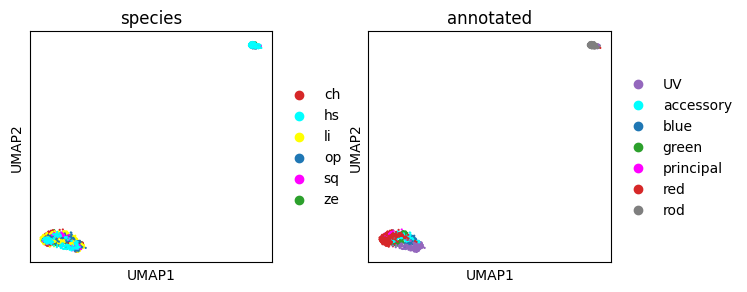

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.


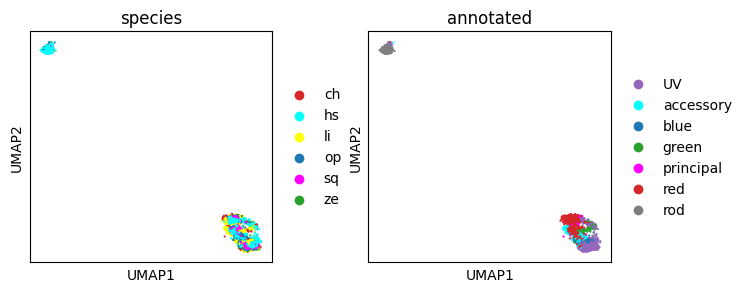

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 4.358797291914622 minutes.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 4.263901805877685 minutes.
Elapsed time: 4.256582009792328 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

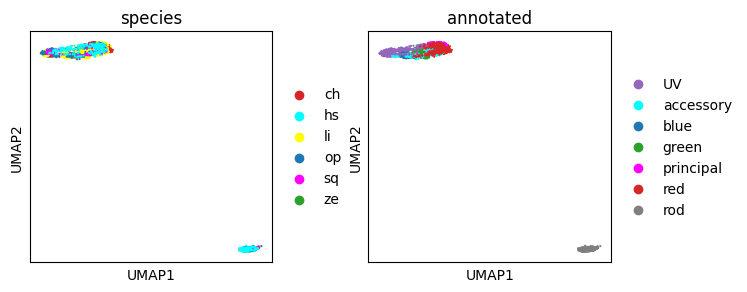

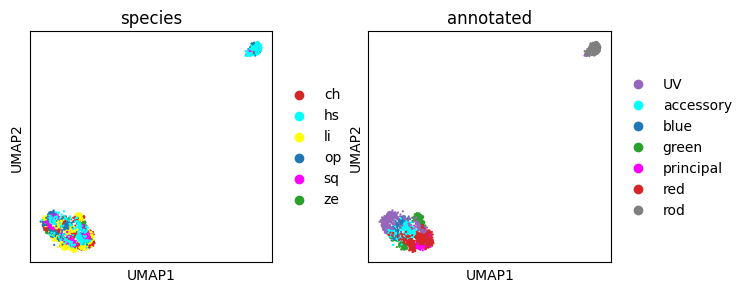

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.


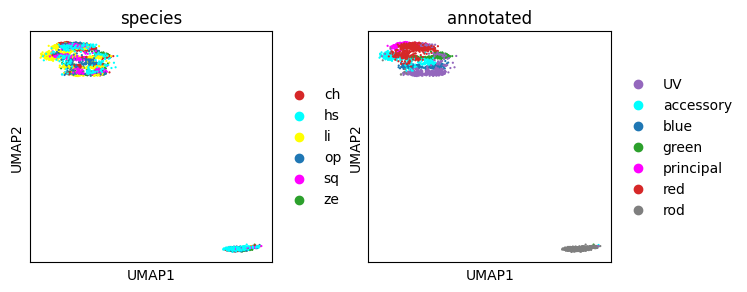

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in op:annotated.
Finding cluster-specific markers in op:annotated.
Finding cluster-specific markers in op:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 4.276970934867859 minutes.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 4.3456895589828495 minutes.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in sq:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the

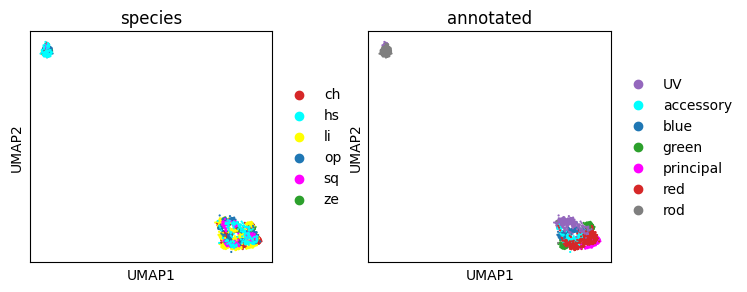

Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ze:annotated.


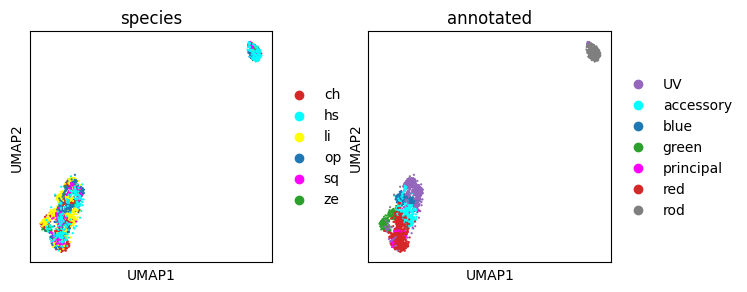

Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in op:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in op:annotated.
Finding cluster-specific markers in op:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.
Elapsed time: 4.360419992605845 minutes.
Finding cluster-specific markers in op:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Finding cluster-specific markers in op:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


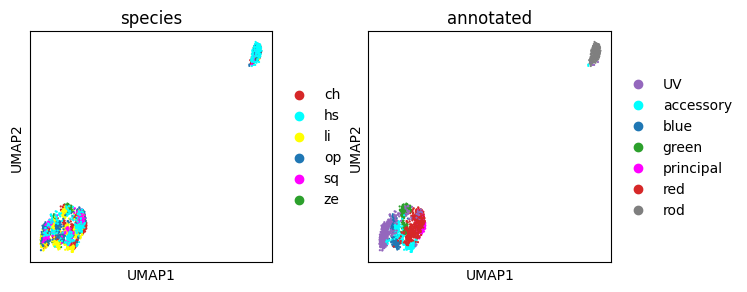

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in op:annotated.
Elapsed time: 4.419020537535349 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in sq:annotated.


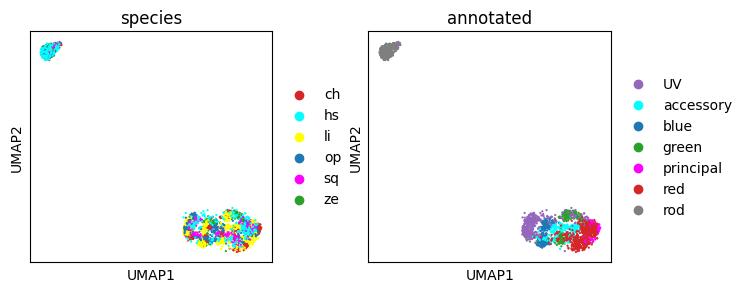

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in op:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in hs:annotated.


In [10]:
from multiprocessing import Pool
from itertools import repeat

def wrapper(seed, downsample):
    return SAMapTrial(expfiles, gnnm, plot = False, seed = seed, downsample = downsample)
#     return MappingTable

if __name__ == '__main__':
    with Pool() as p:
        expres = p.starmap(wrapper, zip(range(nIter), repeat(100)))

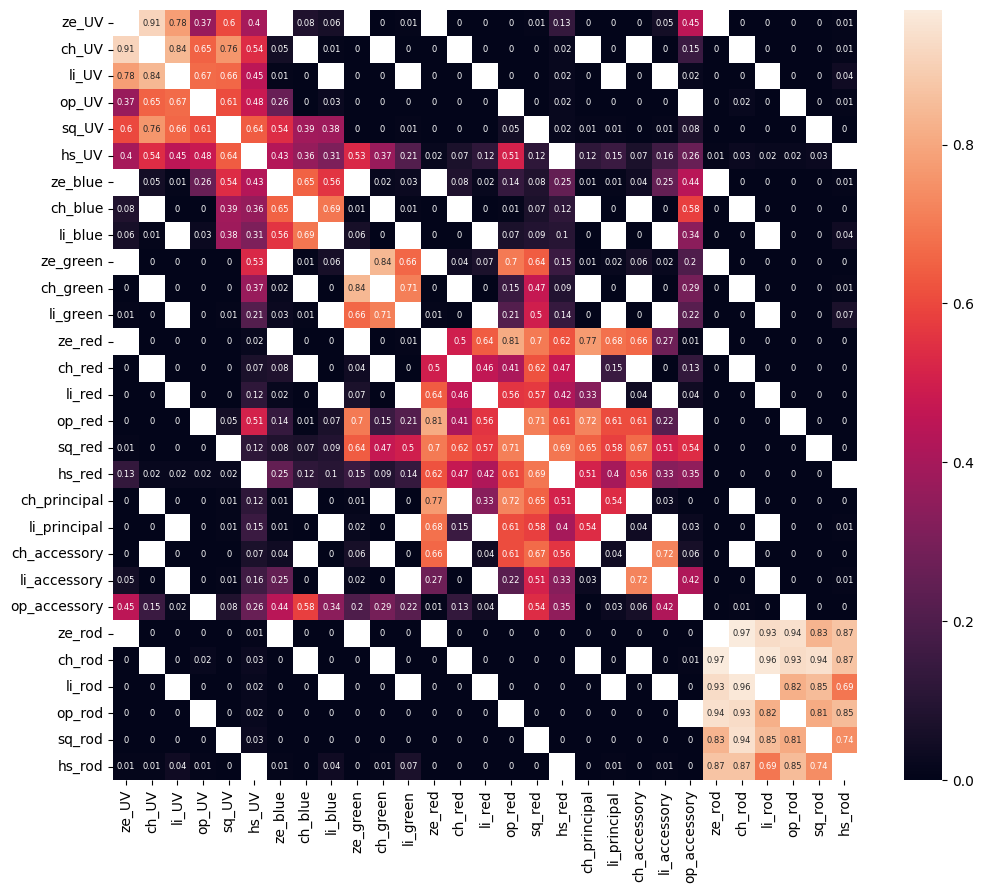

In [13]:
MeanTable(expres)

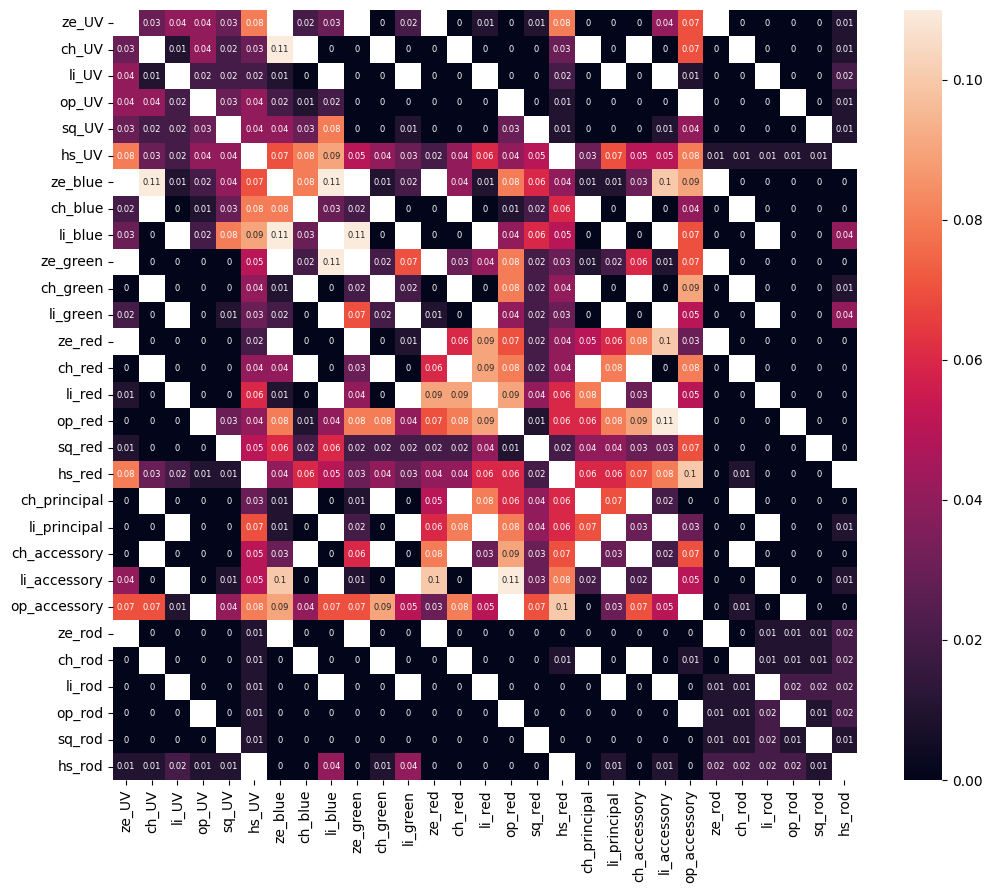

In [15]:
StdTable(expres)

# Figure 2: Single cone integration

In [4]:
path = '../../Species_Objects/Cone_Objects/updated/'
specieslist = ['ZebrafishAdult', 'Chicken', 'Lizard', 'Squirrel', 'Human']
identlist = ['ze', 'ch', 'li', 'sq', 'hs']
zechlisqhs_single = dict((identlist[i], path + species + '_single.h5ad') for i, species in enumerate(specieslist))
zechlisqhs_double = dict((identlist[i], path + species + '_double.h5ad') for i, species in enumerate(specieslist))

zechlisqhs_single

{'ze': '../../Species_Objects/Cone_Objects/updated/ZebrafishAdult_single.h5ad',
 'ch': '../../Species_Objects/Cone_Objects/updated/Chicken_single.h5ad',
 'li': '../../Species_Objects/Cone_Objects/updated/Lizard_single.h5ad',
 'sq': '../../Species_Objects/Cone_Objects/updated/Squirrel_single.h5ad',
 'hs': '../../Species_Objects/Cone_Objects/updated/Human_single.h5ad'}

/tmp/ipykernel_16436/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_16436/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_16436/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_16436/1391746

/tmp/ipykernel_16436/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_16436/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_16436/1391746452.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_16436/1391746

RUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAMRUNNING SAM









Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0
Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0
Iteration: 0, Convergence: 1.0

Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0





Iteration: 1, Convergence: 0.9369726789764383
Iteration: 1, Convergence: 0.9370027139276473
Iteration: 1, Convergence: 0.9363034889741297Iteration: 1, Convergence: 0.9367777703793402

Iteration: 1, Convergence: 0.9371355414019873
Iteration: 1, Convergence: 0.9354994831459044Iteration: 1, Convergence: 0.9363821222877017Iteration: 1, Convergence: 0.9364806246086416


Iteration: 1, Convergence: 0.9373505123432739
Iteration: 1, Convergence: 0.936360871512124
Iteration: 2, Convergence: 0.017554236217244404
Iteration: 2, Convergence: 0.0187520767759621
Iteration: 2, Con

Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Correcting data with means. 2.7945282459259033
Rescaling edge weights by expression correlations.
Correcting data with means. 5.225937366485596
Not updating the manifold...
Correcting data with means. 4.6841654777526855
Correcting data with means. 4.5300352573394775
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Rescaling edge weights by expression correl

ze  0.845611  0.621970  0.692283  0.658826  0.000000
Calculating gene-gene correlations in the homology graph...
Prepping datasets for translation.
Translating feature spaces pairwise.
Prepping datasets for translation.
Projecting data into joint latent space. 1.6196479797363281
Translating feature spaces pairwise.
Prepping datasets for translation.
Prepping datasets for translation.
Translating feature spaces pairwise.
Projecting data into joint latent space. 1.4836561679840088
Translating feature spaces pairwise.
Prepping datasets for translation.
Correcting data with means. 1.6777057647705078
Prepping datasets for translation.
Prepping datasets for translation.
Translating feature spaces pairwise.
Prepping datasets for translation.
Translating feature spaces pairwise.
Translating feature spaces pairwise.
Translating feature spaces pairwise.
Prepping datasets for translation.
Projecting data into joint latent space. 1.6159942150115967
Expanding neighbourhoods of species ze...
Expandi

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Elapsed time: 2.7616236090660093 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

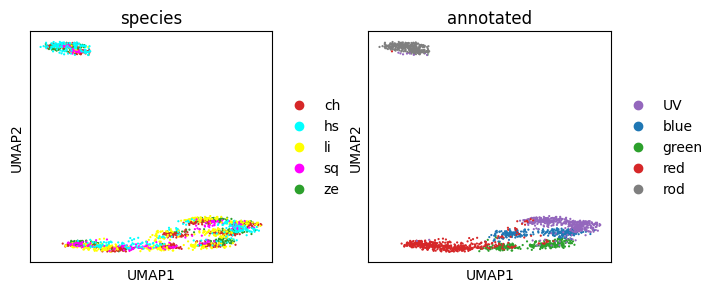

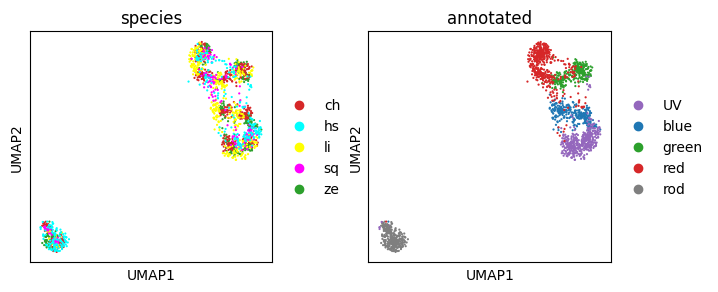

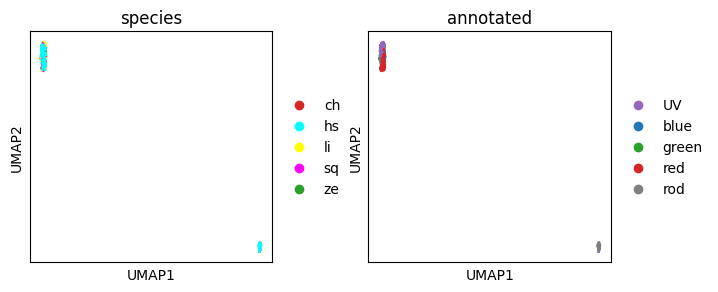

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.Finding cluster-specific markers in ze:annotated.

Elapsed time: 2.7753164807955426 minutes.
Finding cluster-specific markers in ch:annotated.
Elapsed time: 2.7984790166219073 minutes.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ch:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Elapsed time: 2.8018897652626036 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Elapsed time: 2.8239805936813354 minutes.


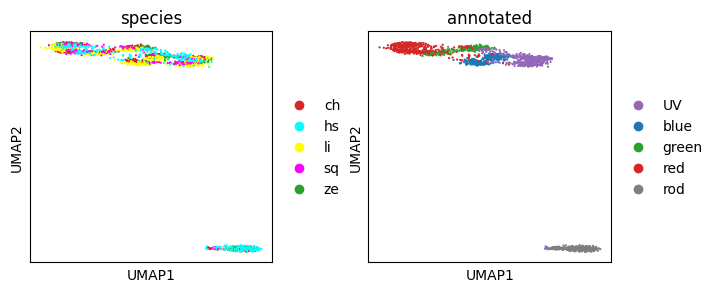

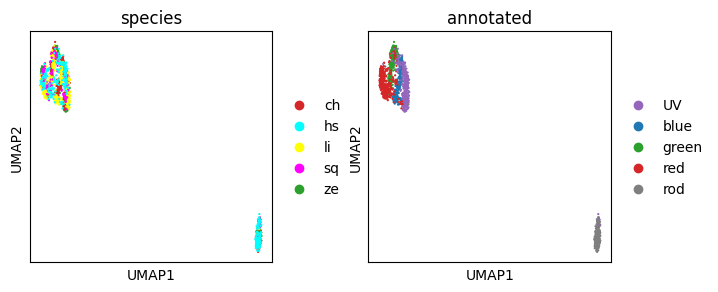

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ze:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.


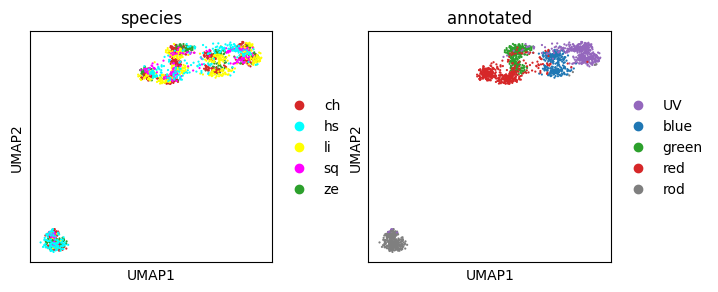

Finding cluster-specific markers in ze:annotated.


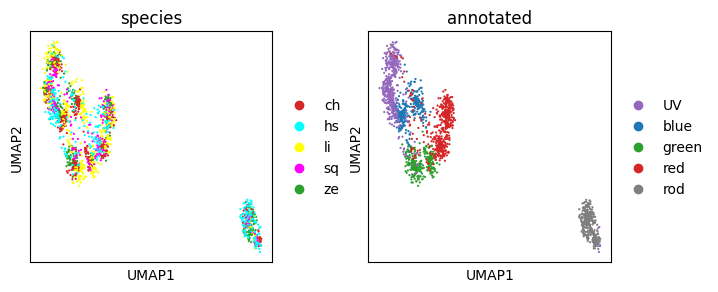

Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ze:annotated.
Elapsed time: 2.83865309158961 minutes.
Finding cluster-specific markers in sq:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in ch:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.


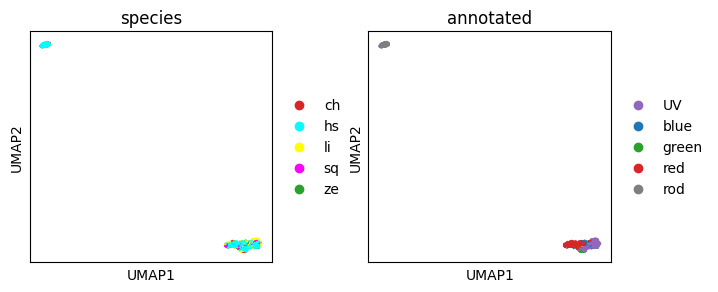

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 2.9761777957280477 minutes.
Finding cluster-specific markers in hs:annotated.
Finding 

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

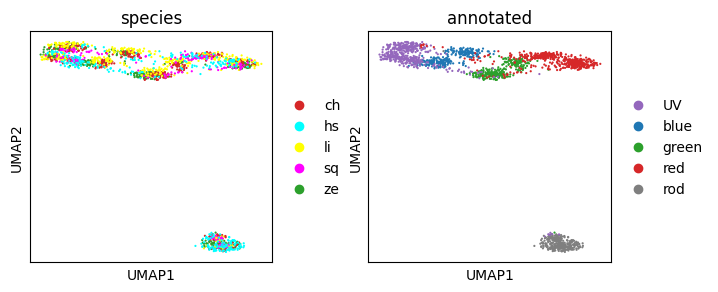

Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in hs:annotated.
Elapsed time: 2.6986388007799786 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ig

Finding cluster-specific markers in ch:annotated.


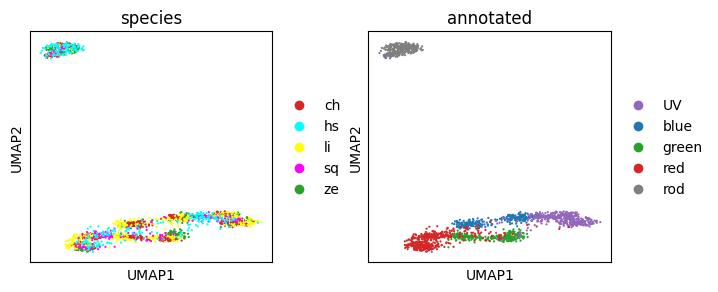

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in hs:annotated.


In [5]:
from multiprocessing import Pool

def wrapper(seed, downsample):
    return SAMapTrial(zechlisqhs_single, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        zechlisqhs_single_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))

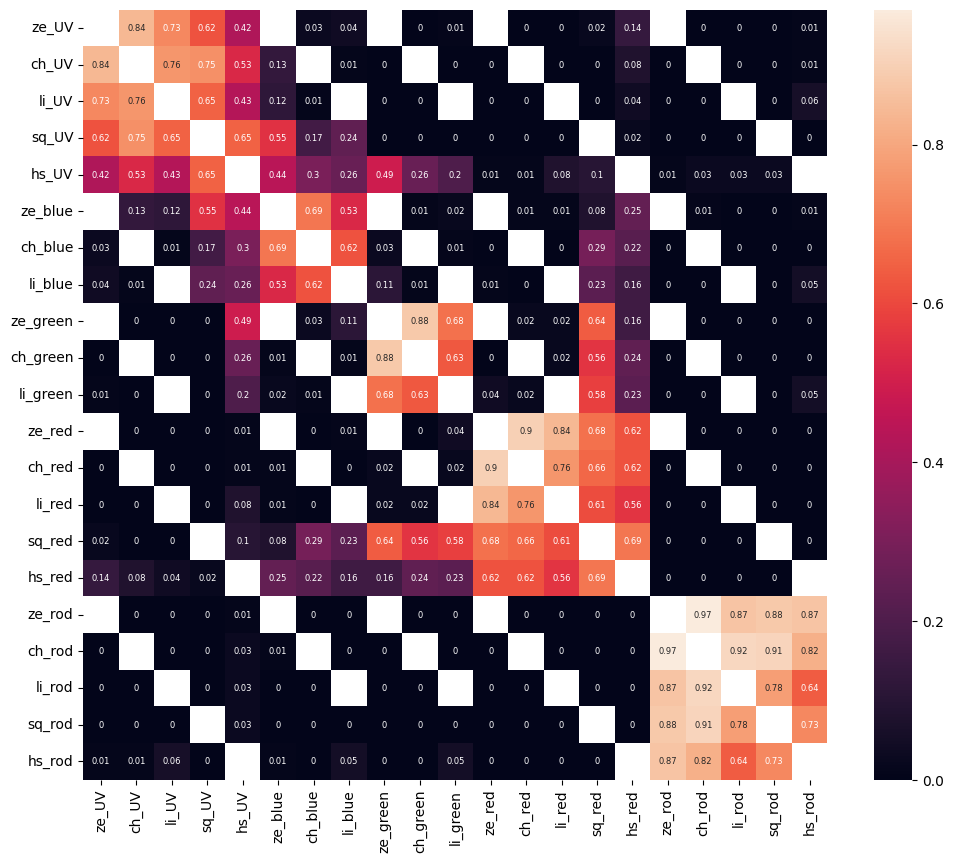

In [6]:
MeanTable(zechlisqhs_single_res)

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

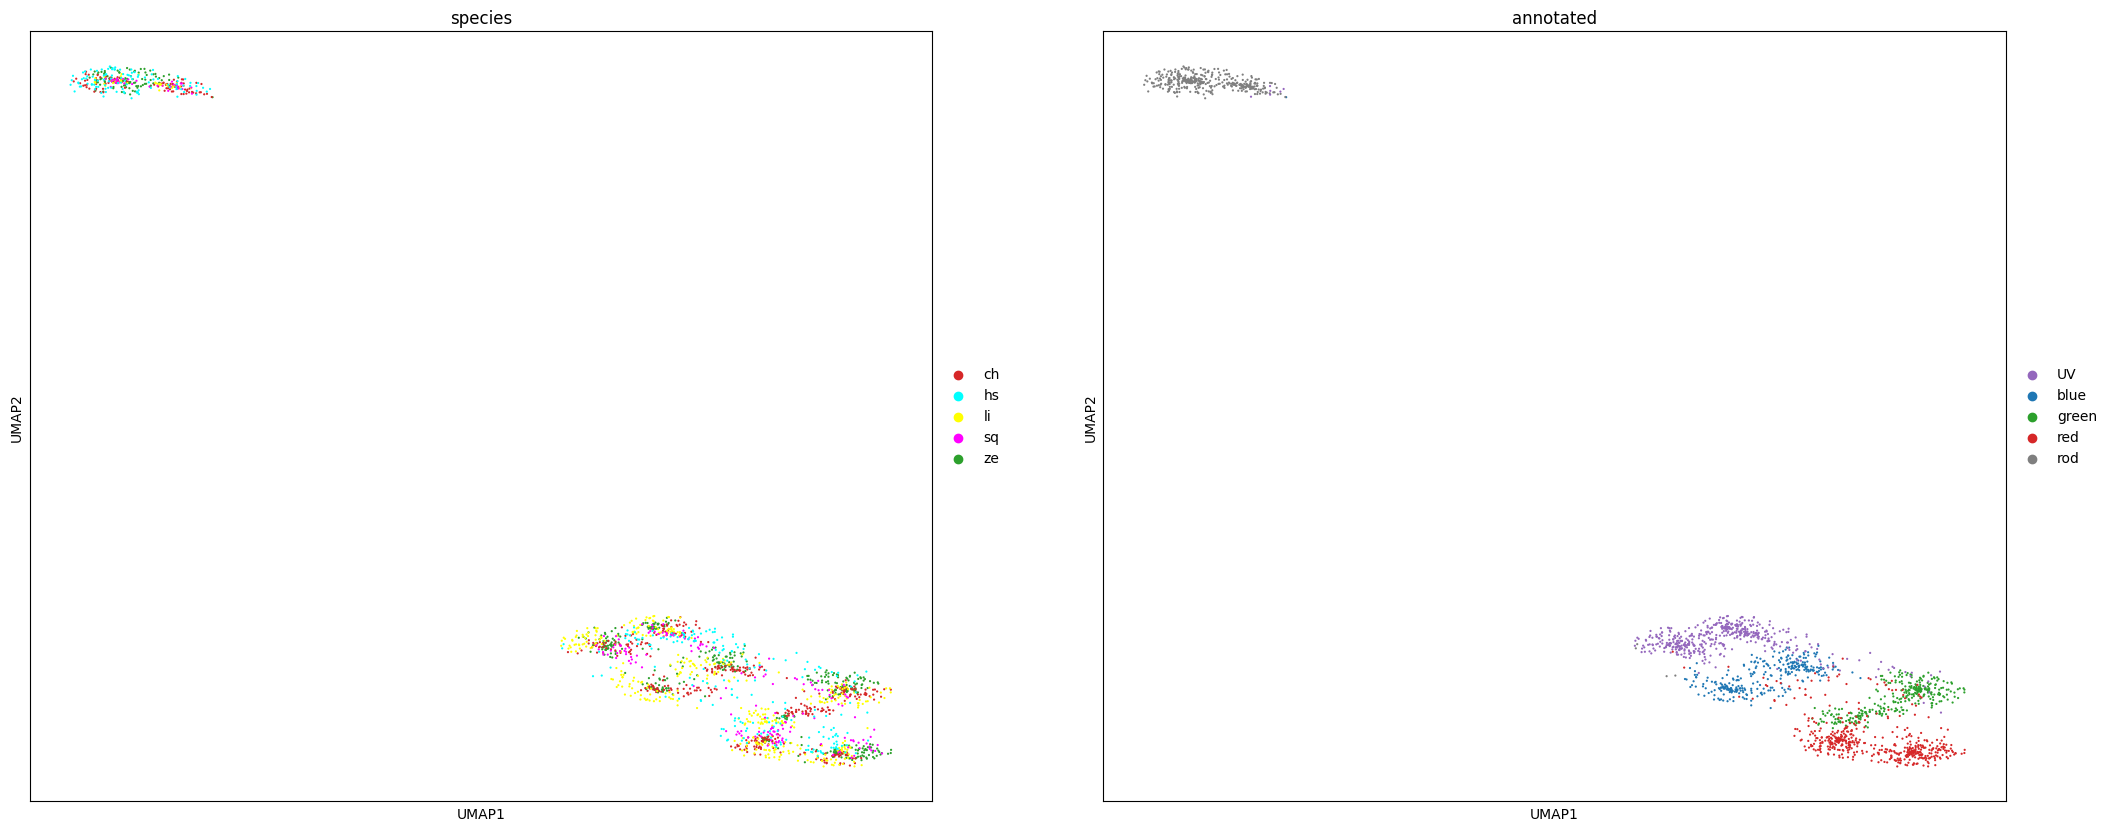

In [30]:
# save example
PlotUMAP(zechlisqhs_single_res[0][0])
samap.utils.save_samap(zechlisqhs_single_res[0][0], '../../../storage/samap/pkl/zechlisqhs_single_res_0.samap')
# potential umap

In [9]:
# gene pairs
gpf = zechlisqhs_single_res[0][2]
gene_pairs = gpf.find_all(align_thr=0.10)
gene_pairs.to_csv('MappingTable/zechlisqhs_genepairs.csv')

# Figure 3: Double cone integration

/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_37356/3741285

/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_37356/3741285

RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0


/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])
/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAMRUNNING SAMRUNNING SAM
Iteration: 0, Convergence: 1.0


Iteration: 0, Convergence: 1.0Iteration: 0, Convergence: 1.0



/tmp/ipykernel_37356/3741285200.py:116: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_downsampled = adatas[0].concatenate(*adatas[1:])


RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.9355002011065987
Iteration: 1, Convergence: 0.9367724189211755
Iteration: 1, Convergence: 0.9371355414019873
Iteration: 1, Convergence: 0.9364806246086416
Iteration: 1, Convergence: 0.936360871512124
Iteration: 1, Convergence: 0.9363034889741297
Iteration: 1, Convergence: 0.9370027139276473
Iteration: 1, Convergence: 0.9363821222877017
Iteration: 2, Convergence: 0.018216450573094855
Iteration: 2, Convergence: 0.02001853479831205
Iteration: 1, Convergence: 0.9369726789764383
Iteration: 1, Convergence: 0.9373505123432739
Iteration: 2, Convergence: 0.018974379973686065
Iteration: 2, Convergence: 0.01617470979572506
Iteration: 2, Convergence: 0.017495214612573178
Iteration: 2, Convergence: 0.018863863837458514
Elapsed time: 11.785654306411743 seconds
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 2, Convergence: 0.0173934448154

Indegree coarsening
Rescaling edge weights by expression correlations.
Correcting data with means. 2.8666887283325195
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Rescaling edge weights by expression correlations.
Rescaling edge weights by expression correlations.
Correcting data with means. 2.9132330417633057
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of species li...
Expanding neighbourhoods of species sq...
Expanding neighbourhoods of species hs...
Indegree coarsening
Correcting data with means. 3.170471668243408
Projecting data into joint latent space. 2.7489020824432373
Rescaling edge weights by expression correlations.
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighbourhoods of spec

Translating feature spaces pairwise.
Translating feature spaces pairwise.
Projecting data into joint latent space. 2.8025476932525635
Projecting data into joint latent space. 2.6192758083343506
Prepping datasets for translation.
Prepping datasets for translation.
Translating feature spaces pairwise.
Prepping datasets for translation.
Translating feature spaces pairwise.
Translating feature spaces pairwise.
Prepping datasets for translation.
Projecting data into joint latent space. 1.7077653408050537
Prepping datasets for translation.
Translating feature spaces pairwise.
Correcting data with means. 1.8569962978363037
Correcting data with means. 2.1201066970825195
Projecting data into joint latent space. 1.7945129871368408
Prepping datasets for translation.
Projecting data into joint latent space. 1.7765929698944092
Translating feature spaces pairwise.
Translating feature spaces pairwise.
Expanding neighbourhoods of species ze...
Expanding neighbourhoods of species ch...
Expanding neighb

ze  0.876134  0.629640  0.746398  0.653020  0.000000
Running UMAP on the stitched manifolds.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          ch        hs        li        sq        ze
ch  0.000000  0.555380  0.726291  0.611163  0.767985
hs  0.753372  0.000000  0.642450  0.652042  0.827476
li  0.739771  0.489684  0.000000  0.558531  0.705081
sq  0.775152  0.621639  0.709333  0.000000  0.822832
ze  0.883474  0.636194  0.755448  0.679049  0.000000
Running UMAP on the stitched manifolds.
Elapsed time: 3.224941583474477 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


Elapsed time: 3.28189431031545 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the

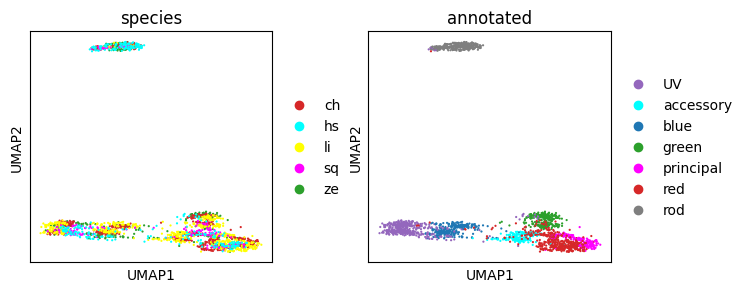

Finding cluster-specific markers in ze:annotated.


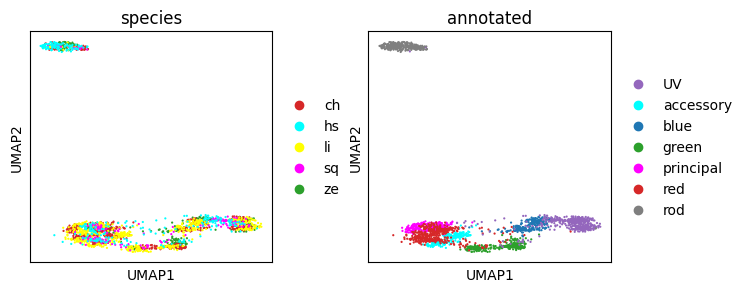

Finding cluster-specific markers in ze:annotated.
Elapsed time: 3.1162106871604918 minutes.
Finding cluster-specific markers in ch:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

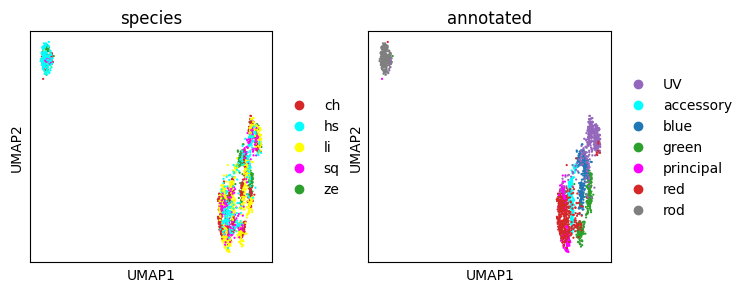

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.
Elapsed time: 3.1049543102582295 minutes.
Elapsed time: 3.2169504324595133 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

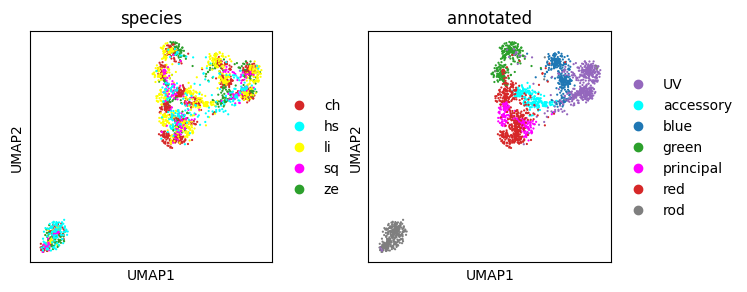

Finding cluster-specific markers in ze:annotated.
Elapsed time: 3.0559417883555096 minutes.


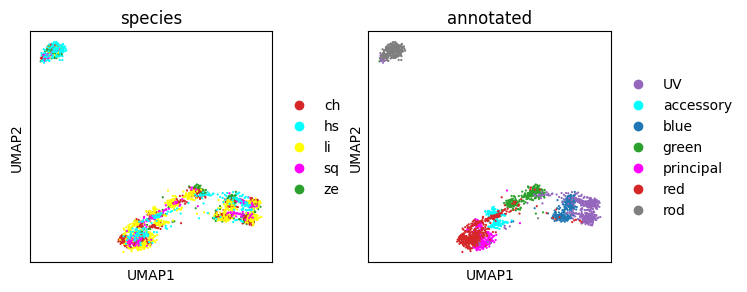

Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ze:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.


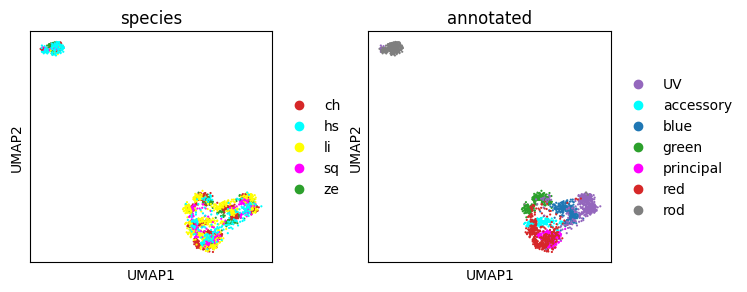

Finding cluster-specific markers in ze:annotated.
Elapsed time: 3.0966737230618793 minutes.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in sq:annotated.


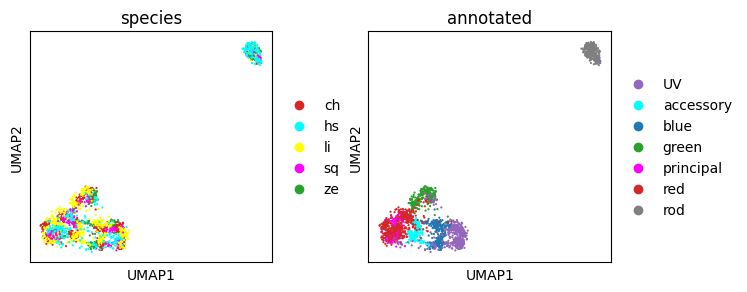

Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in sq:annotated.
Elapsed time: 3.076505597432454 minutes.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.


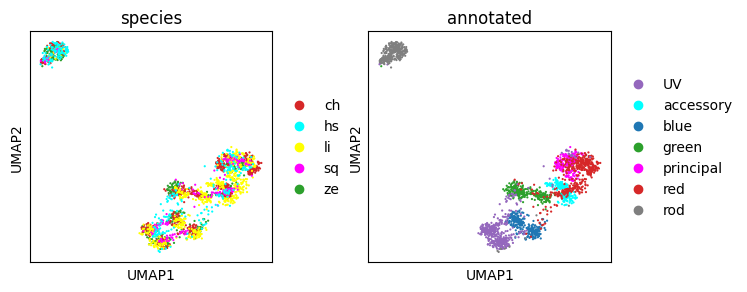

Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in sq:annotated.
Elapsed time: 3.071463640530904 minutes.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in li:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

Elapsed time: 3.1007044951121014 minutes.
Finding cluster-specific markers in ch:annotated.


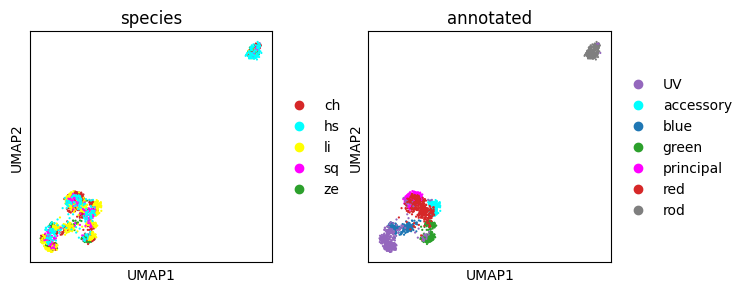

Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in hs:annotated.


/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

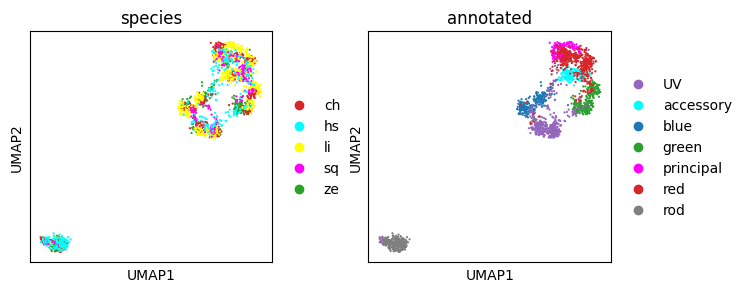

Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in ze:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in ch:annotated.
Finding cluster-specific markers in hs:annotated.

Finding cluster-specific markers in ch:annotated.Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in li:annotated.
Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in li:annotated.

Finding cluster-specific markers in sq:annotated.Finding cluster-specific markers in hs:annotated.
Finding cluster-specific markers in sq:annotated.
Finding cluster-specific markers in hs:annotated.


In [10]:
def wrapper(seed, downsample):
    return SAMapTrial(zechlisqhs_double, gnnm, plot = False, seed = seed, downsample = downsample)

if __name__ == '__main__':
    with Pool() as p:
        zechlisqhs_double_res = p.starmap(wrapper, zip(range(nIter), repeat(100)))
        

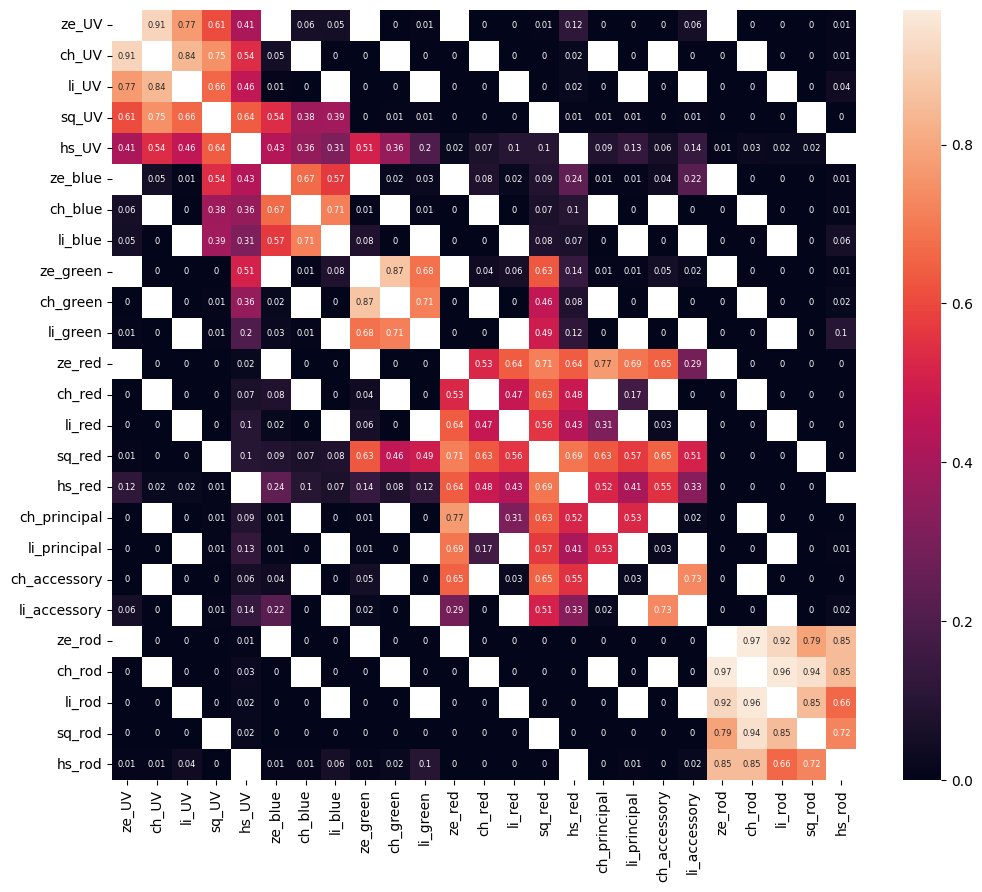

In [8]:
MeanTable(zechlisqhs_double_res)

In [ ]:
StdTable(zechlisqhs_double_res)

In [7]:
[zechlisqhs_single_res[i][1].to_csv('MappingTable/zechlisqhs_single_' + str(i) + '.csv') for i in range(nIter)]
[zechlisqhs_double_res[i][1].to_csv('MappingTable/zechlisqhs_double_' + str(i) + '.csv') for i in range(nIter)]

[None, None, None, None, None, None, None, None, None, None]

/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/global/home/users/dtommasini/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

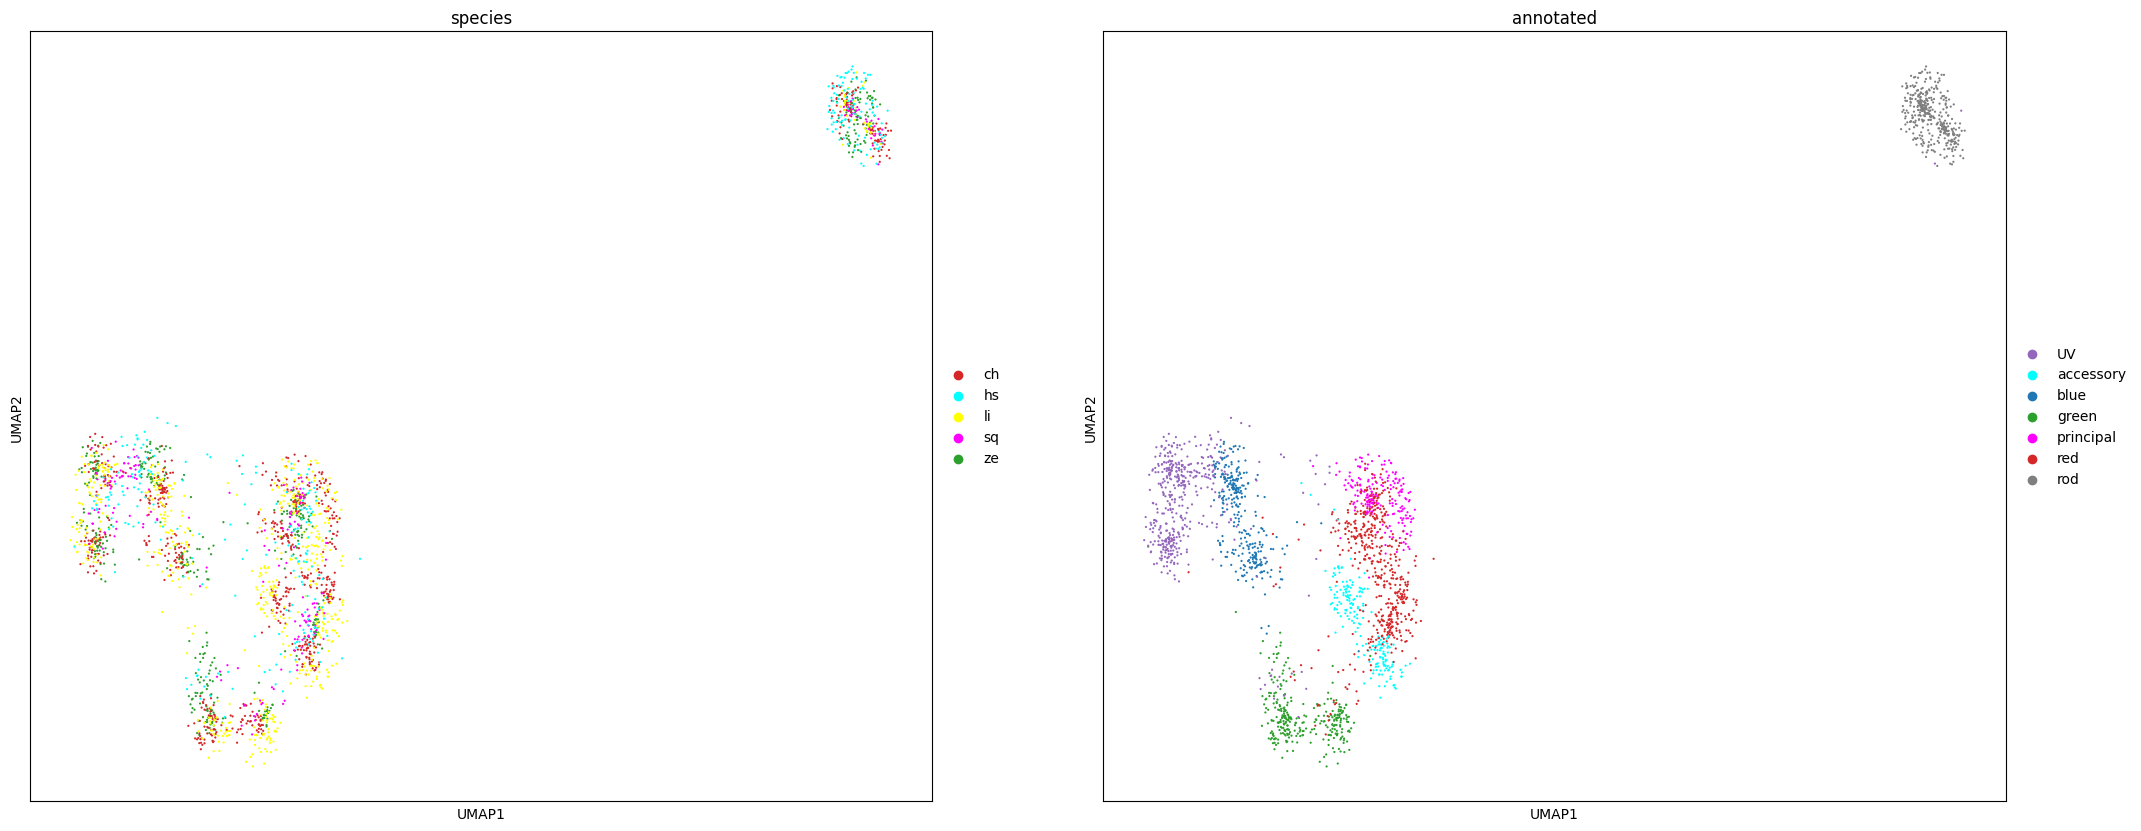

In [12]:
# save example
PlotUMAP(zechlisqhs_double_res[2][0])
samap.utils.save_samap(zechlisqhs_double_res[2][0], '../../../storage/samap/pkl/zechlisqhs_double_res_2.samap')
# potential umap


# Figure 4: joint PCA

/tmp/ipykernel_50825/3741285200.py:235: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)
/tmp/ipykernel_50825/3741285200.py:235: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)


The lists are identical


/tmp/ipykernel_50825/3741285200.py:235: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)
/tmp/ipykernel_50825/3741285200.py:235: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)


The lists are identical
               ch_UV  ch_accessory   ch_blue  ch_green  ch_principal  \
ch_NME6     2.449490     -0.408248 -0.408248 -0.408248     -0.408248   
ch_ARSA     1.606408     -0.632397 -0.632397 -0.632397     -0.632397   
ch_DENND6B  0.415975     -1.221201  0.674330 -1.743335     -0.042343   
ch_SBF1     0.383071     -0.235060 -1.331759 -0.651506      0.714512   
ch_SCO2    -0.863007     -0.863007  1.289439 -0.863007      0.981716   

              ch_red    ch_rod     li_UV  li_accessory   li_blue  li_green  \
ch_NME6    -0.408248 -0.408248 -0.745824     -0.453645  1.097329 -0.532266   
ch_ARSA    -0.632397  1.555578 -0.711713      0.391806 -0.186830 -0.259619   
ch_DENND6B  0.998768  0.917805 -1.074855      0.231486 -1.674424 -0.142946   
ch_SBF1     1.875932 -0.755190 -0.505001      0.896305 -0.590901 -0.292090   
ch_SCO2     1.180872 -0.863007  0.773576      1.240245  0.442431 -1.469501   

            li_principal    li_red    li_rod     ze_UV   ze_blue  ze_green

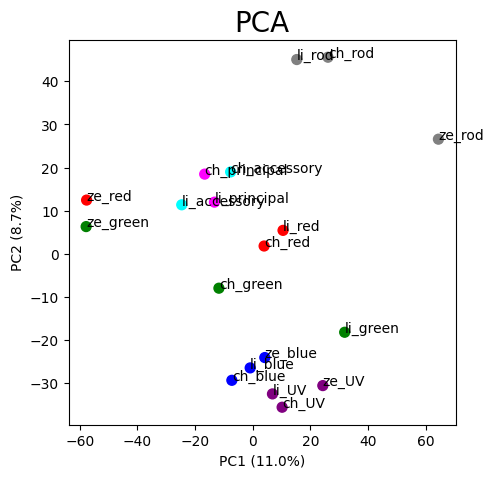

In [27]:
sm = samap.utils.load_samap('../../../storage/samap/pkl/zechlisqhs_double_res_2.samap')
ze_expr, ch_expr, ze_trans, homology_matrix = translate_feature_space(sm, "ze", "ch", scale = True)
li_expr, ch_expr, li_trans, homology_matrix = translate_feature_space(sm, "li", "ch", scale = True)
merged = standardize_expression_matrices([ch_expr, li_trans, ze_trans], ids = ['ch','li','ze'])
pca_coords = PlotPCA(merged, binary = -0.15)
pca_coords.to_csv('MappingTable/pca_coords.csv')